In [73]:
#!/usr/bin/env python3
#pip install  rioxarray==0.3.1
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import rioxarray
import numpy as np
import geopandas as gpd
import cartopy.crs as ccrs
import rasterio
import os
import matplotlib.colors
scriptsdir = os.getcwd()
from scipy.interpolate import griddata
from functools import reduce
import xarray
import itertools
import matplotlib.colors as mcolors


In [ ]:
##### Difference future - past ##### 
##### SDM results only ##### - SDM models seperate 


models=["GAM"] 
taxas =["Amphibians"]

model_names = ['GFDL-ESM2M', 'IPSL-CM5A-LR', 'HadGEM2-ES', 'MIROC5']

years= ['1845', '1990', '1995', '2009', '2010', '2020', '2026', '2032', '2048', '2050', 
                 '2052', '2056', '2080', '2100', '2150', '2200', '2250']

for taxa in taxas:
    for model in models:
        dir_species = "/storage/scratch/users/ch21o450/data/LandClim_Output/" + model + "/" + taxa + "/EWEMBI/"
        available_file = os.listdir(dir_species)
        available_names = [x.split("_[1146].nc")[0] for x in available_file]


species_names = available_names[:50]

#newvalue
for taxa in taxas:
    for model in models:
        def newvalue_fun(time, model, netcdf_path_format, is_historical=False, scenario=None):
            newvalue_dict = {model_name: {} for model_name in model_names}
            sum_bin_dict = {model_name: {} for model_name in model_names}

            for model_name in model_names:
                for species_name in species_names:
                    if is_historical:
                        ds = xr.open_dataset(netcdf_path_format.format(model, taxa, species_name, time), decode_times=False)
                    else:
                        ds = xr.open_dataset(netcdf_path_format.format(model, taxa, model_name, scenario, species_name, time), decode_times=False)
                    newvalue = ds["newvalue"]
                    sum_bin = ds["sum_bin"]

                    newvalue_dict[model_name][species_name] = newvalue
                    sum_bin_dict[model_name][species_name] = sum_bin

            projections_dict = {}

            for species_name in species_names:
                value_list = []
                for model_name in model_names:
                    value_bin = newvalue_dict[model_name][species_name]
                    value_list.append(value_bin)
                value_bin_concat = xr.concat(value_list, dim="model")
                mean_value_bin = value_bin_concat.mean(dim="model")
                projections_dict[species_name] = mean_value_bin

            value_bin_list = list(projections_dict.values())
            mean_value_bin = xr.concat(value_bin_list, dim="species").mean(dim="species")

            return mean_value_bin


        #newvalue
        historical_time = 1146
        future_times = [35, 65, 85]
        scenarios = ["rcp26", "rcp60"]

        netcdf_path_format_future = "/storage/scratch/users/ch21o450/data/LandClim_Output/{}/{}/{}/{}/{}_[{}].nc"
        netcdf_path_format_hist = "/storage/scratch/users/ch21o450/data/LandClim_Output/{}/{}/EWEMBI/{}_[{}].nc"

        mean_hist = newvalue_fun(historical_time, model, netcdf_path_format_hist, is_historical=True)

        fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(26, 24), subplot_kw={'projection': ccrs.PlateCarree()})


        cmap = matplotlib.colors.ListedColormap(['white', 'green'])
        countries = gpd.read_file(
                      gpd.datasets.get_path("naturalearth_lowres"))

        plot_idx = 0
        year_indices = {1146: '1995', 35: '2050', 65: '2080', 85: '2100'}

        for future_time in future_times:
            if future_time == 35 or future_time == 65:
                model_names = ['GFDL-ESM2M', 'IPSL-CM5A-LR', 'HadGEM2-ES', 'MIROC5']
                scenarios = ["rcp26", "rcp60"]
            elif future_time == 85:
                model_names = ['IPSL-CM5A-LR', 'HadGEM2-ES', 'MIROC5']
                scenarios = ["rcp26"]

            for scenario in scenarios:
                if future_time == 85 and scenario == "rcp60":
                    continue

                mean_future = newvalue_fun(future_time, model, netcdf_path_format_future, is_historical=False, scenario=scenario)
                difference = mean_future - mean_hist
                ax = axes.flatten()[plot_idx]
                im = ax.pcolormesh(difference['lon'].values, difference['lat'].values, difference.values, transform=ccrs.PlateCarree(), cmap="RdBu_r")

                countries.plot(ax=ax, color="lightgray", zorder=1, alpha=0.3)
                ax.set_title(f"Difference between {year_indices[future_time]} and {year_indices[historical_time]} for {scenario}")

                cbar = plt.colorbar(im, ax=ax, fraction=0.024, pad=0.04)
                #cbar.set_ticks([-0.2, 0, 0.2])

                plot_idx += 1
        axes.flatten()[-1].set_visible(False)

        plt.tight_layout()
        plt.show()




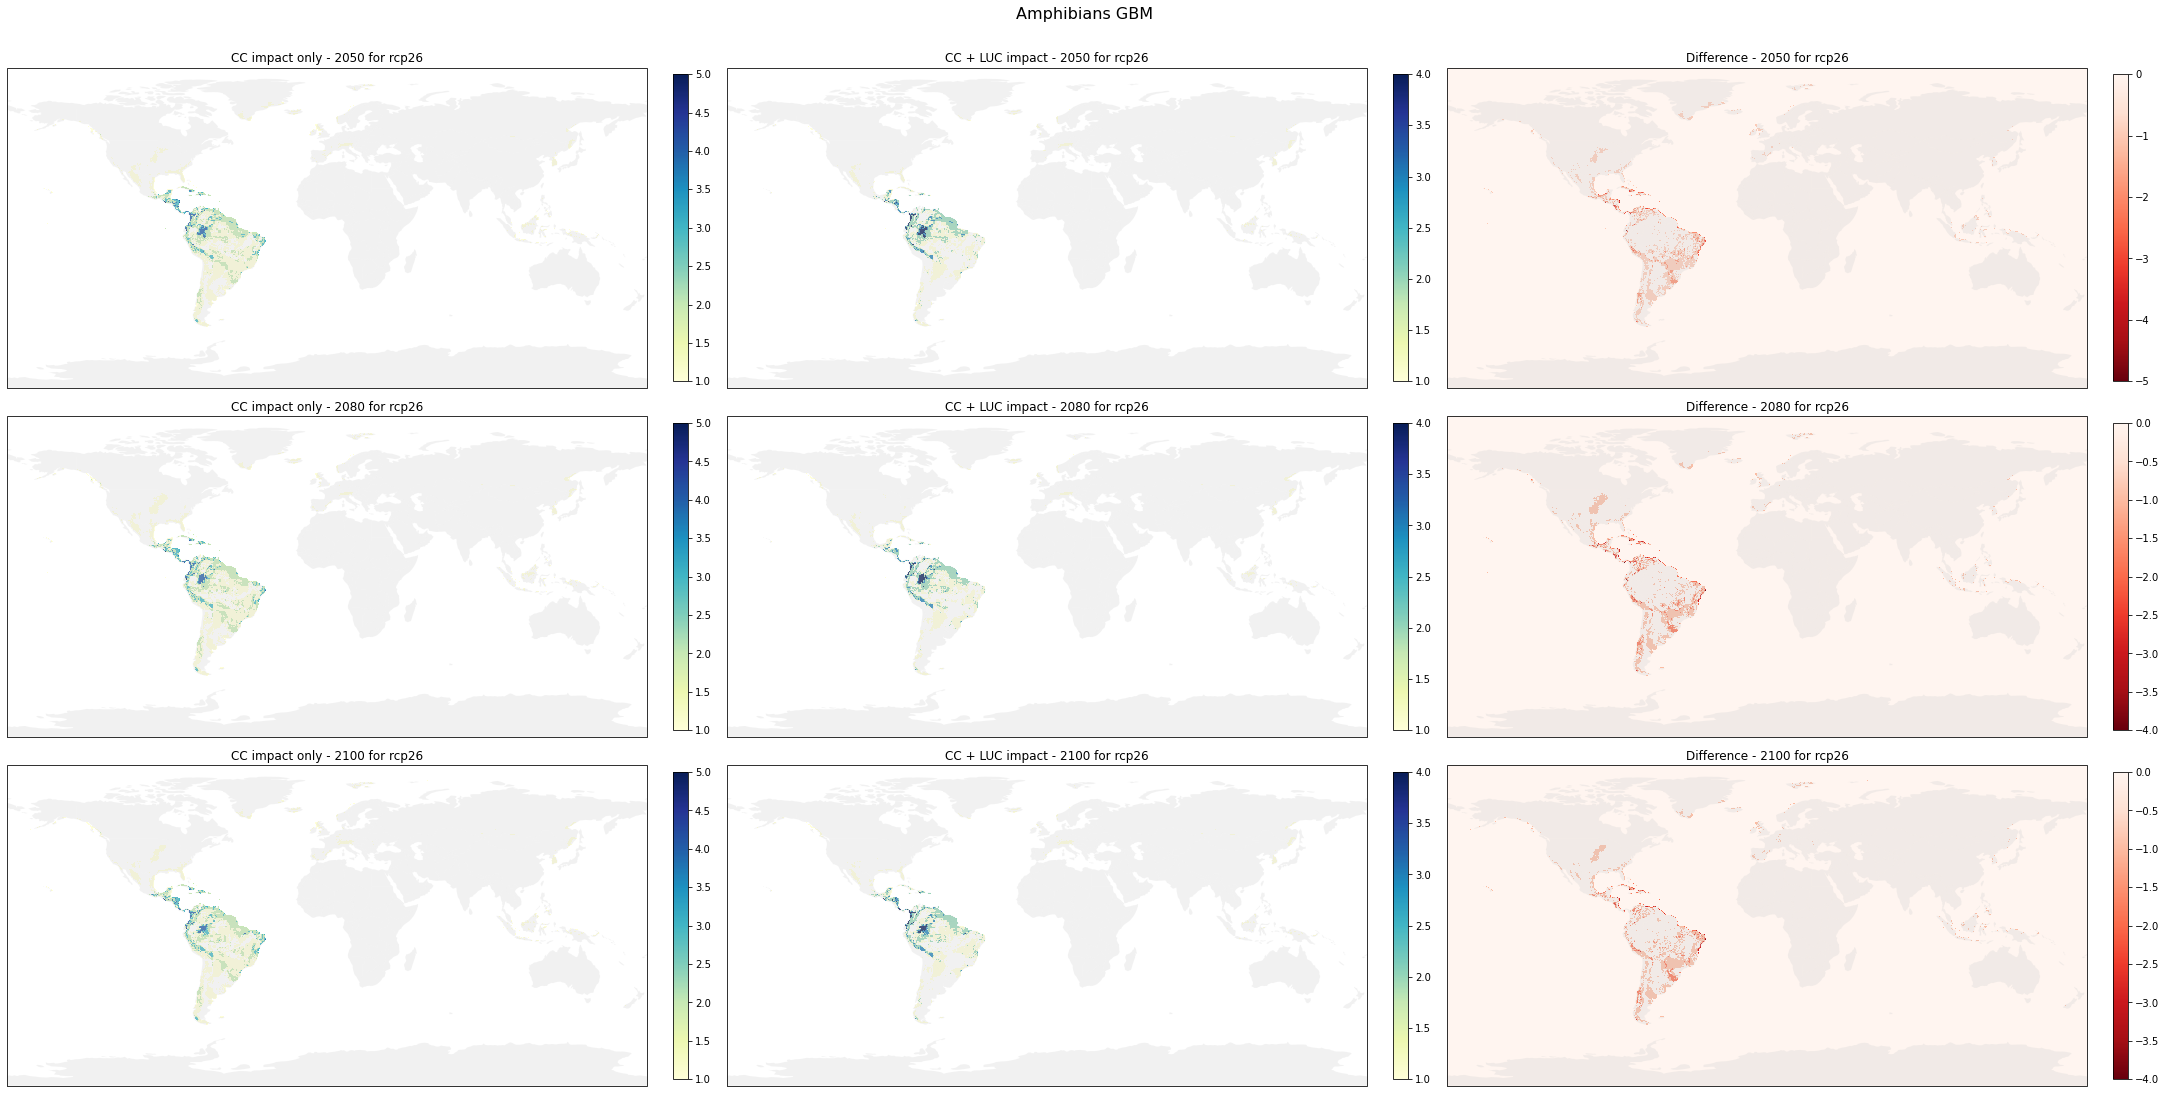

In [82]:
#### Comparison with vs without Land-use filter #### species count
#one scenario at a time # 


models=["GBM"] 
taxas =["Amphibians"]

model_names = ['GFDL-ESM2M', 'IPSL-CM5A-LR', 'HadGEM2-ES', 'MIROC5']
#model_names = ['GFDL-ESM2M']

years= ['1845', '1990', '1995', '2009', '2010', '2020', '2026', '2032', '2048', '2050', 
                 '2052', '2056', '2080', '2100', '2150', '2200', '2250']

for taxa in taxas:
    for model in models:
        dir_species = "/storage/scratch/users/ch21o450/data/LandClim_Output/" + model + "/" + taxa + "/EWEMBI/"
        available_file = os.listdir(dir_species)
        available_names = [x.split("_[1146].nc")[0] for x in available_file]


species_names = available_names[:10]

#newvalue
for taxa in taxas:
    for model in models:
        def newvalue_fun(time, model, netcdf_path_format, is_historical=False, scenario=None):
            newvalue_dict = {model_name: {} for model_name in model_names}
            sum_bin_dict = {model_name: {} for model_name in model_names}

            for model_name in model_names:
                for species_name in species_names:
                    ds = xr.open_dataset(netcdf_path_format.format(model, taxa, model_name, scenario, species_name, time), decode_times=False)
                    newvalue = ds["newvalue"]
                    sum_bin = ds["sum_bin"]

                    newvalue_dict[model_name][species_name] = newvalue
                    sum_bin_dict[model_name][species_name] = sum_bin

            projections_dict = {}

            for species_name in species_names:
                value_list = []
                for model_name in model_names:
                    value_bin = newvalue_dict[model_name][species_name]
                    #value_bin = value_bin.where(value_bin > 0, 1)
                    value_bin = (value_bin > 0.05)
                    
                    value_list.append(value_bin)
                value_bin_concat = xr.concat(value_list, dim="model")
                mean_value_bin = value_bin_concat.mean(dim="model")
                projections_dict[species_name] = mean_value_bin

            value_bin_list = list(projections_dict.values())
            mean_value_bin = xr.concat(value_bin_list, dim="species").sum(dim="species")
            mean_value_bin = mean_value_bin.where(mean_value_bin > 0, 0)
            return mean_value_bin

        def calculate_mean(time, model, netcdf_path_format, is_historical=False, scenario=None):
            newvalue_dict = {model_name: {} for model_name in model_names}
            sum_bin_dict = {model_name: {} for model_name in model_names}

            for model_name in model_names:
                for species_name in species_names:
                    if is_historical:
                        ds = xr.open_dataset(netcdf_path_format.format(model, taxa, species_name, time), decode_times=False)
                    else:
                        ds = xr.open_dataset(netcdf_path_format.format(model, taxa, model_name, scenario, species_name, time), decode_times=False)
                    sum_bin = ds["sum_bin"]

                    sum_bin =  (sum_bin > 0.05)

                    sum_bin_dict[model_name][species_name] = sum_bin

            projections_dict = {}

            for species_name in species_names:
                sum_bin_list = []
                for model_name in model_names:
                    sum_bin = sum_bin_dict[model_name][species_name]
                    sum_bin_list.append(sum_bin)
                sum_bin_concat = xr.concat(sum_bin_list, dim="model")
                mean_sum_bin = sum_bin_concat.mean(dim="model")
                projections_dict[species_name] = mean_sum_bin

            mean_sum_bin_list = list(projections_dict.values())
            mean_sum_bin = xr.concat(mean_sum_bin_list, dim="species").sum(dim="species")
            mean_sum_bin = mean_sum_bin.where(mean_sum_bin > 0, 0)

            return mean_sum_bin


        future_times = [35, 65, 85]
        scenarios = ["rcp26"]

        netcdf_path_format_future = "/storage/scratch/users/ch21o450/data/LandClim_Output/{}/{}/{}/{}/{}_[{}].nc"


        fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(30, 26), subplot_kw={'projection': ccrs.PlateCarree()}, layout="compressed")


        cmap = matplotlib.colors.ListedColormap(['white', 'green'])
        countries = gpd.read_file(
                      gpd.datasets.get_path("naturalearth_lowres"))

        plot_idx = 0
        year_indices = {1146: '1995', 35: '2050', 65: '2080', 85: '2100'}

        for future_time in future_times:
            if future_time == 35 or future_time == 65:
                model_names = ['GFDL-ESM2M', 'IPSL-CM5A-LR', 'HadGEM2-ES', 'MIROC5']
                scenarios = ["rcp26"]
            elif future_time == 85:
                model_names = ['IPSL-CM5A-LR', 'HadGEM2-ES', 'MIROC5']
                scenarios = ["rcp26"]
            for scenario in scenarios:
                if future_time == 85 and scenario == "rcp60":
                    continue

                # Call both functions and unpack their return values
                mean_value_bin = newvalue_fun(future_time, model, netcdf_path_format_future, is_historical=False, scenario=scenario)
                mean_sum_bin =  calculate_mean(future_time, model, netcdf_path_format_future, is_historical=False, scenario=scenario)
                mean_sum_bin = mean_sum_bin.isel(time=0)

                # Calculate the difference between the two
                diff_bin = mean_sum_bin -mean_value_bin

                # Create three subplots for each future time and scenario
                if plot_idx >= len(axes.flatten()):
                    break
                ax1 = axes.flatten()[plot_idx]
                ax2 = axes.flatten()[plot_idx + 1]
                ax3 = axes.flatten()[plot_idx + 2]

                # Plot newvalue_bin in the left subplot
                im1 = ax1.pcolormesh(mean_value_bin['lon'].values, mean_value_bin['lat'].values, np.where(mean_value_bin.values > 0, mean_value_bin.values, np.nan), transform=ccrs.PlateCarree(), cmap="YlGnBu")
                countries.plot(ax=ax1, color="lightgray", zorder=1, alpha=0.3)
                ax1.set_title(f"CC impact only - {year_indices[future_time]} for {scenario}")
                cbar1 = plt.colorbar(im1, ax=ax1, fraction=0.024, pad=0.04)

                # Plot sum_bin in the middle subplot
                im2 = ax2.pcolormesh(mean_sum_bin['lon'].values, mean_sum_bin['lat'].values,  np.where(mean_sum_bin.values > 0, mean_sum_bin.values, np.nan), transform=ccrs.PlateCarree(), cmap="YlGnBu")
                countries.plot(ax=ax2, color="lightgray", zorder=1, alpha=0.3)
                ax2.set_title(f"CC + LUC impact - {year_indices[future_time]} for {scenario}")
                cbar2 = plt.colorbar(im2, ax=ax2, fraction=0.024, pad=0.04)

                # Plot diff_bin in the right subplot
                im3 = ax3.pcolormesh(diff_bin['lon'].values, diff_bin['lat'].values, diff_bin.values, transform=ccrs.PlateCarree(), cmap="Reds_r")
                countries.plot(ax=ax3, color="lightgray", zorder=1, alpha=0.3)
                ax3.set_title(f"Difference - {year_indices[future_time]} for {scenario}")
                
                #norm = mcolors.TwoSlopeNorm(vmin=diff_bin.min(), vmax = diff_bin.max(), vcenter=0)

                cbar3 = plt.colorbar(im3, ax=ax3, fraction=0.024, pad=0.04, norm=norm)
                
                # Increase the plot index by 3 to move to the next triplet of subplots
                plot_idx += 3


        #plt.tight_layout()
        plt.suptitle(taxa+ " " + model, size=16, y=0.8)
        plt.show()


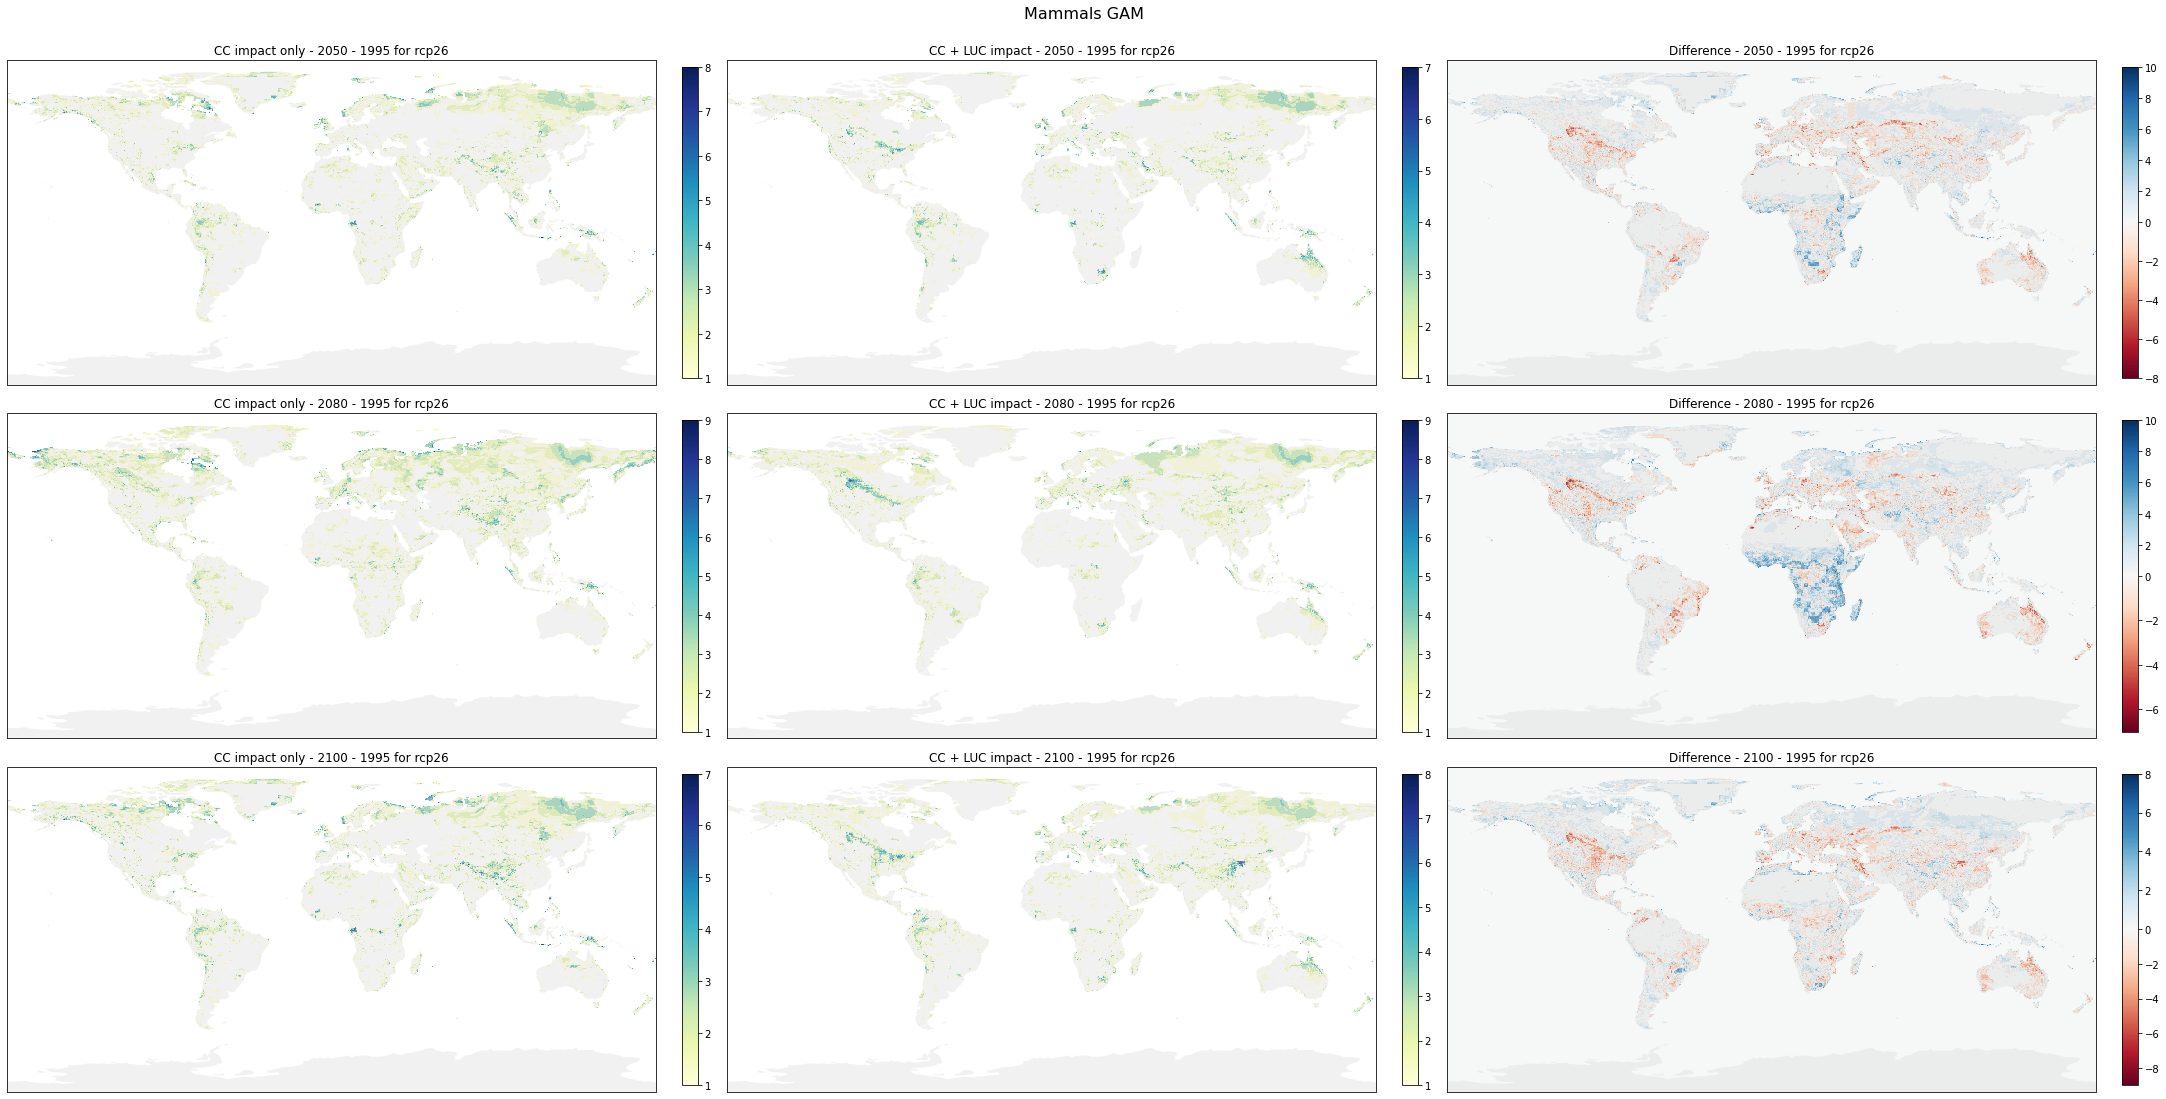

In [91]:
models = ["GAM"]
taxas = ["Mammals"]

model_names = ['GFDL-ESM2M', 'IPSL-CM5A-LR', 'HadGEM2-ES', 'MIROC5']
years = ['1845', '1990', '1995', '2009', '2010', '2020', '2026', '2032', '2048', '2050',
         '2052', '2056', '2080', '2100', '2150', '2200', '2250']

for taxa in taxas:
    for model in models:
        dir_species = "/storage/scratch/users/ch21o450/data/LandClim_Output/" + model + "/" + taxa + "/EWEMBI/"
        available_file = os.listdir(dir_species)
        available_names = [x.split("_[1146].nc")[0] for x in available_file]

species_names = available_names[:100]

#newvalue
for taxa in taxas:
    for model in models:
        def newvalue_fun(time, model, netcdf_path_format, is_historical=False, scenario=None):
            newvalue_dict = {model_name: {} for model_name in model_names}
            sum_bin_dict = {model_name: {} for model_name in model_names}

            for model_name in model_names:
                for species_name in species_names:
                    if is_historical:
                        ds = xr.open_dataset(netcdf_path_format.format(model, taxa, species_name, time), decode_times=False)
                    else:
                        ds = xr.open_dataset(netcdf_path_format.format(model, taxa, model_name, scenario, species_name, time), decode_times=False)

                    newvalue = ds["newvalue"]
                    sum_bin = ds["sum_bin"]

                    newvalue_dict[model_name][species_name] = newvalue
                    sum_bin_dict[model_name][species_name] = sum_bin

            projections_dict = {}

            for species_name in species_names:
                value_list = []
                for model_name in model_names:
                    value_bin = newvalue_dict[model_name][species_name]
                    #value_bin = value_bin.where(value_bin > 0, 1)
                    value_bin = (value_bin > 0.05)
                    
                    value_list.append(value_bin)
                value_bin_concat = xr.concat(value_list, dim="model")
                mean_value_bin = value_bin_concat.mean(dim="model")
                projections_dict[species_name] = mean_value_bin

            value_bin_list = list(projections_dict.values())
            mean_value_bin = xr.concat(value_bin_list, dim="species").sum(dim="species")
            mean_value_bin = mean_value_bin.where(mean_value_bin > 0, 0)
            return mean_value_bin

        def calculate_mean(time, model, netcdf_path_format, is_historical=False, scenario=None):
            newvalue_dict = {model_name: {} for model_name in model_names}
            sum_bin_dict = {model_name: {} for model_name in model_names}

            for model_name in model_names:
                for species_name in species_names:
                    if is_historical:
                        ds = xr.open_dataset(netcdf_path_format.format(model, taxa, species_name, time), decode_times=False)
                    else:
                        ds = xr.open_dataset(netcdf_path_format.format(model, taxa, model_name, scenario, species_name, time), decode_times=False)
                    sum_bin = ds["sum_bin"]

                    sum_bin = (sum_bin > 0.05)

                    sum_bin_dict[model_name][species_name] = sum_bin

            
            projections_dict = {}

            for species_name in species_names:
                sum_bin_list = []
                for model_name in model_names:
                    sum_bin = sum_bin_dict[model_name][species_name]
                    sum_bin_list.append(sum_bin)
                sum_bin_concat = xr.concat(sum_bin_list, dim="model")
                mean_sum_bin = sum_bin_concat.mean(dim="model")
                projections_dict[species_name] = mean_sum_bin

            mean_sum_bin_list = list(projections_dict.values())
            mean_sum_bin = xr.concat(mean_sum_bin_list, dim="species").sum(dim="species")
            mean_sum_bin = mean_sum_bin.where(mean_sum_bin > 0, 0)

            return mean_sum_bin

        historical_time = 1146
        future_times = [35, 65, 85]
        scenarios = ["rcp26"]
        model_names = ['GFDL-ESM2M', 'IPSL-CM5A-LR', 'HadGEM2-ES', 'MIROC5']
        netcdf_path_format_future = "/storage/scratch/users/ch21o450/data/LandClim_Output/{}/{}/{}/{}/{}_[{}].nc"
        netcdf_path_format_hist = "/storage/scratch/users/ch21o450/data/LandClim_Output/{}/{}/EWEMBI/{}_[{}].nc"

        mean_value_bin_hist = newvalue_fun(historical_time, "GAM", netcdf_path_format_hist, is_historical=True)
        mean_sum_bin_hist = calculate_mean(historical_time, "GAM", netcdf_path_format_hist, is_historical=True)

        mean_sum_bin_hist = mean_sum_bin_hist.isel(time=0)


        fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(30, 26), subplot_kw={'projection': ccrs.PlateCarree()}, layout="compressed")
        cmap = matplotlib.colors.ListedColormap(['white', 'green'])
        countries = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))

        plot_idx = 0
        year_indices = {1146: '1995', 35: '2050', 65: '2080', 85: '2100'}

        for future_time in future_times:
            for scenario in scenarios: 
                if future_time == 35 or future_time == 65:
                    model_names = ['GFDL-ESM2M', 'IPSL-CM5A-LR', 'HadGEM2-ES', 'MIROC5']

                elif future_time == 85:
                    model_names = ['IPSL-CM5A-LR', 'HadGEM2-ES', 'MIROC5']


                for scenario in scenarios:
                    if future_time == 85 and scenario == "rcp60":
                        continue

                    mean_value_bin_future = newvalue_fun(future_time, "GAM", netcdf_path_format_future, is_historical=False, scenario=scenario)
                    mean_sum_bin_future = calculate_mean(future_time, "GAM", netcdf_path_format_future, is_historical=False, scenario=scenario)

                    mean_sum_bin_future = mean_sum_bin_future.isel(time=0)

                    # Calculate the differences
                    diff_value_bin = mean_value_bin_future - mean_value_bin_hist
                    diff_sum_bin = mean_sum_bin_future - mean_sum_bin_hist
                    diff = diff_value_bin-diff_sum_bin

                   # Create three subplots for each future time and scenario
                    if plot_idx >= len(axes.flatten()):
                        break
                    ax1 = axes.flatten()[plot_idx]
                    ax2 = axes.flatten()[plot_idx + 1]
                    ax3 = axes.flatten()[plot_idx + 2]

                    # Plot newvalue_bin in the left subplot
                    im1 = ax1.pcolormesh(diff_value_bin['lon'].values, diff_value_bin['lat'].values, np.where(diff_value_bin.values > 0, diff_value_bin.values, np.nan), transform=ccrs.PlateCarree(), cmap="YlGnBu")
                    countries.plot(ax=ax1, color="lightgray", zorder=1, alpha=0.3)
                    ax1.set_title(f"CC impact only - {year_indices[future_time]} - 1995 for {scenario}")
                    cbar1 = plt.colorbar(im1, ax=ax1, fraction=0.024, pad=0.04)

                    # Plot sum_bin in the middle subplot
                    im2 = ax2.pcolormesh(diff_sum_bin['lon'].values, diff_sum_bin['lat'].values,  np.where(diff_sum_bin.values > 0, diff_sum_bin.values, np.nan), transform=ccrs.PlateCarree(), cmap="YlGnBu")
                    countries.plot(ax=ax2, color="lightgray", zorder=1, alpha=0.3)
                    ax2.set_title(f"CC + LUC impact - {year_indices[future_time]} - 1995 for {scenario}")
                    cbar2 = plt.colorbar(im2, ax=ax2, fraction=0.024, pad=0.04)

                    # Plot diff_bin in the right subplot
                    norm = mcolors.TwoSlopeNorm(vmin=diff.min(), vmax=diff.max(), vcenter=0)
                    im3 = ax3.pcolormesh(diff['lon'].values, diff['lat'].values, diff.values, transform=ccrs.PlateCarree(), cmap="RdBu", norm=norm)

                    #im3 = ax3.pcolormesh(diff['lon'].values, diff['lat'].values, diff.values, transform=ccrs.PlateCarree(), cmap="RdBu")
                    countries.plot(ax=ax3, color="lightgray", zorder=1, alpha=0.3)
                    ax3.set_title(f"Difference - {year_indices[future_time]} - 1995 for {scenario}")

                    #norm = mcolors.TwoSlopeNorm(vmin=diff.min(), vmax = diff.max(), vcenter=0)

                    cbar3 = plt.colorbar(im3, ax=ax3, fraction=0.024, pad=0.04, norm=norm)


                    # Increase the plot index by 3 to move to the next triplet of subplots
                    plot_idx += 3


        #plt.tight_layout()
        plt.suptitle(taxa+ " " + model, size=16, y=0.8)
        plt.show()

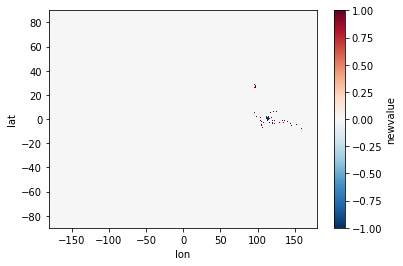

In [55]:
diff_value_bin.plot()

In [5]:
print(sum_bin.dims)

NameError: name 'sum_bin' is not defined

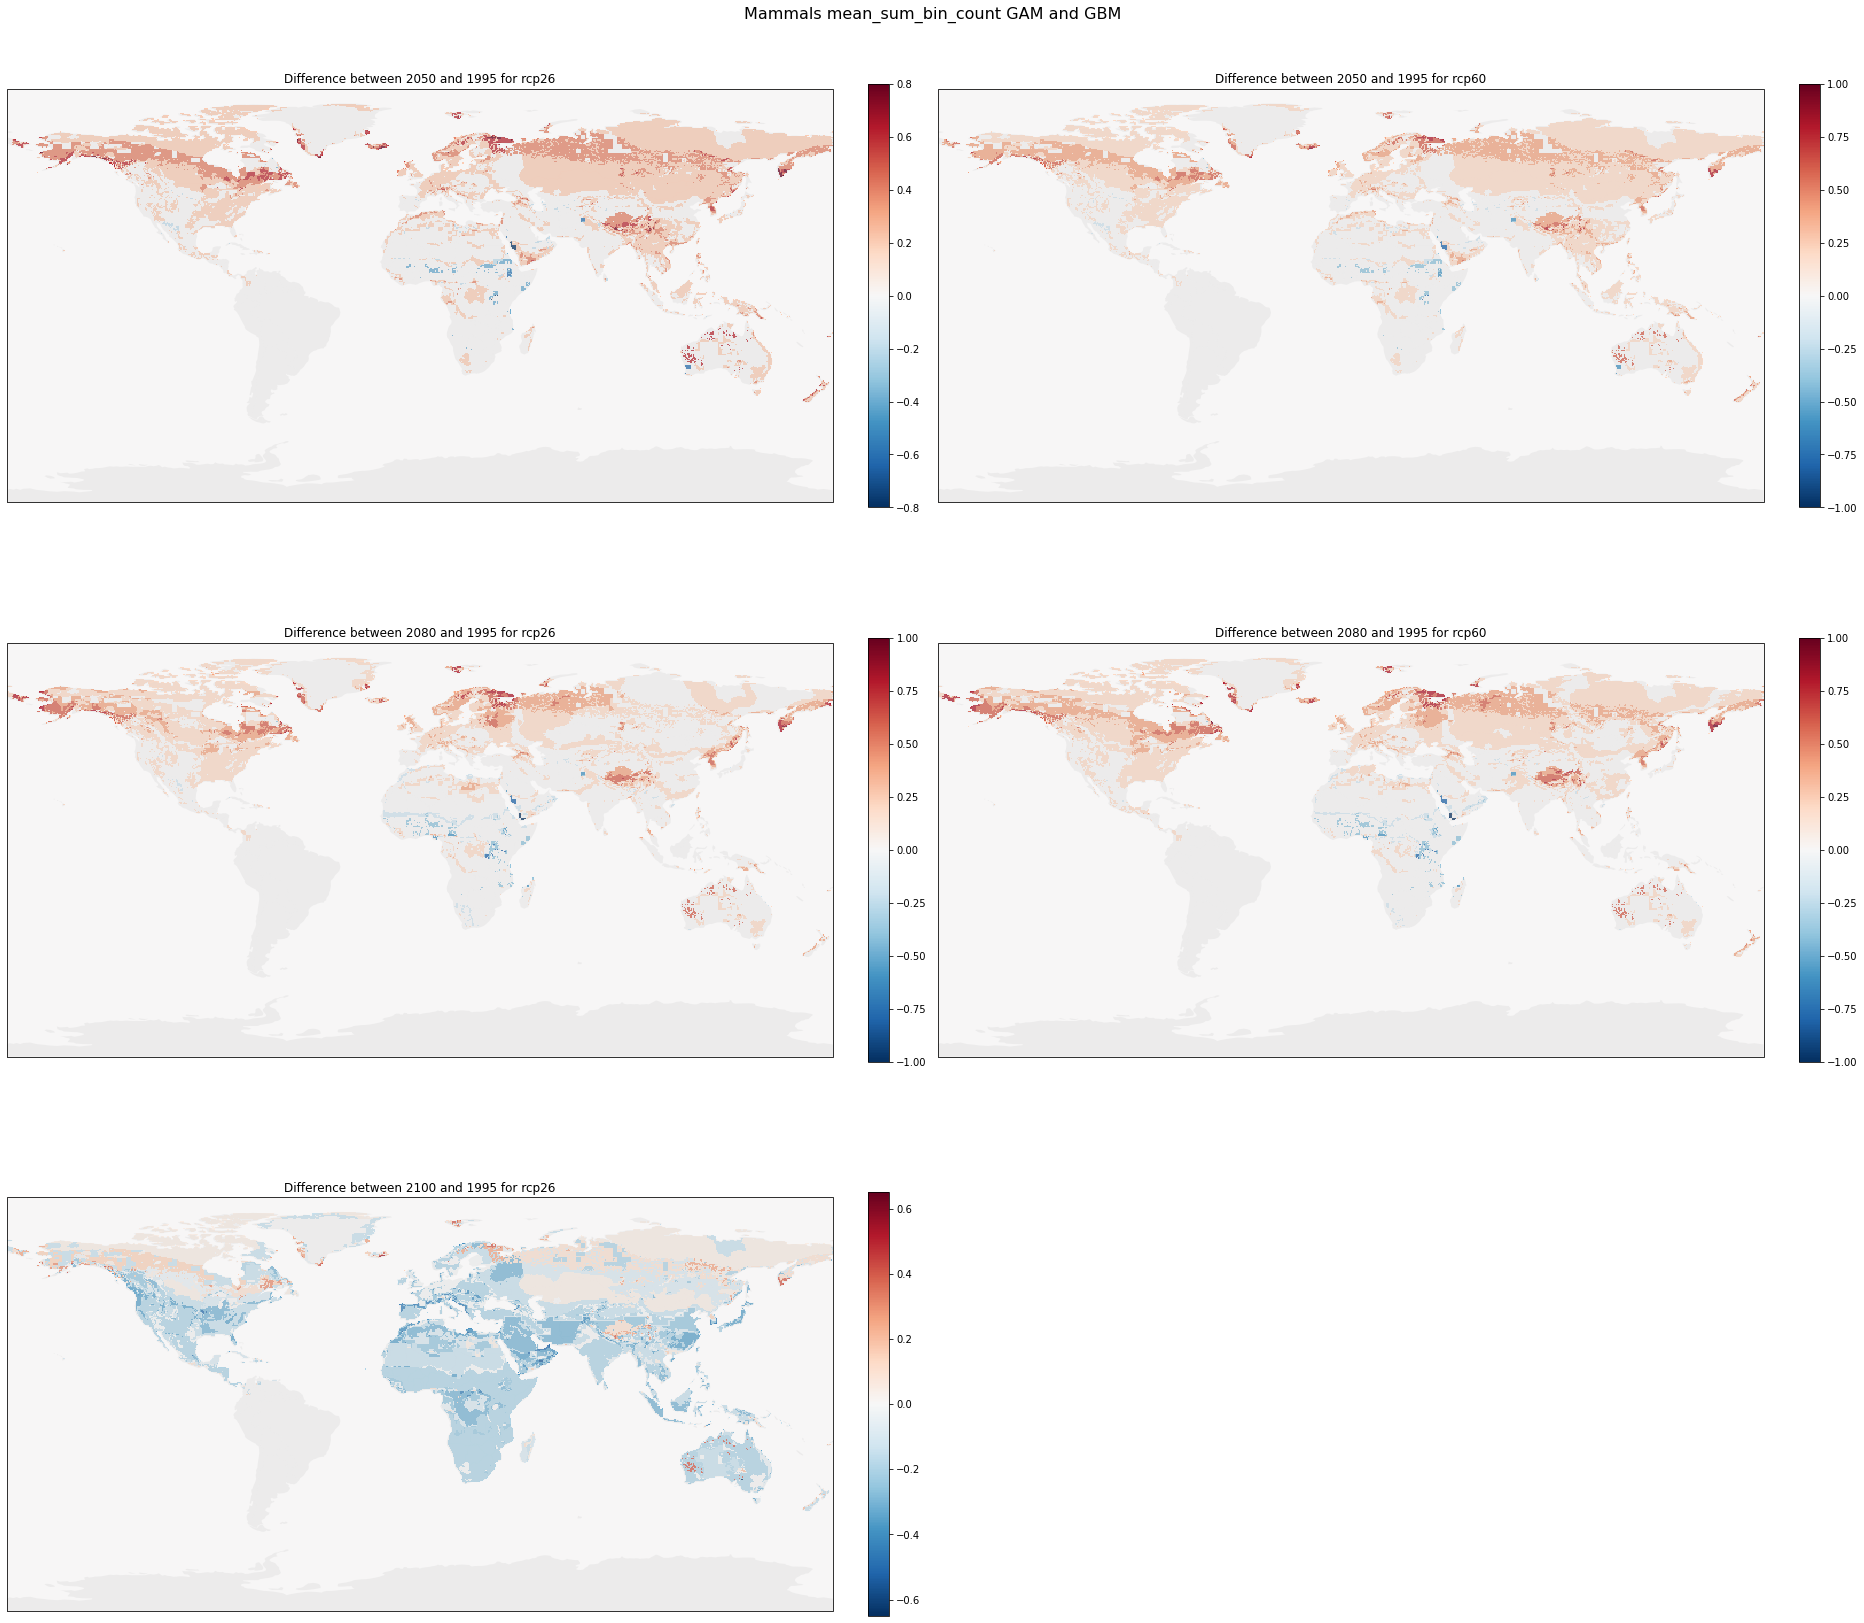

In [12]:
####Landclim effect count (species richness) #### SDM ensemmble mean 

#count 

taxas=["Mammals"]

models=["GAM","GBM"]
years= ['1845', '1990', '1995', '2009', '2010', '2020', '2026', '2032', '2048', '2050', 
                 '2052', '2056', '2080', '2100', '2150', '2200', '2250']
model_names = ['GFDL-ESM2M', 'IPSL-CM5A-LR', 'HadGEM2-ES', 'MIROC5']

for taxa in taxas:
    species_names = {}
    for model in models:
        dir_species = "/storage/scratch/users/ch21o450/data/LandClim_Output/" + model + "/" + taxa + "/EWEMBI/"
        available_file = os.listdir(dir_species)
        available_names = [x.split("_[1146].nc")[0] for x in available_file]
        species_names_model = available_names[:10]
        species_names[model] = species_names_model

for taxa in taxas:
    for model in models:
        def calculate_model_mean(time, models, model_names, netcdf_path_format, is_historical=False, scenario=None):
            species_counts_dict = {model: {model_name: {} for model_name in model_names} for model in models}

            for model in models:
                for model_name in model_names:
                    for species_name in species_names[model]:
                        if is_historical:
                            ds = xr.open_dataset(netcdf_path_format.format(model, taxa,  species_name, time), decode_times=False)
                        else:
                            ds = xr.open_dataset(netcdf_path_format.format(model,taxa, model_name, scenario, species_name, time), decode_times=False)
                        species_counts = xr.DataArray.sum(ds["sum_bin"] > 0, axis=0)  # Count the number of species present in each grid cell
                        species_counts_dict[model][model_name][species_name] = species_counts

            projections_dict = {}

            for species_name in species_names[model]:
                species_counts_list = []
                for model in models:
                    for model_name in model_names:
                        species_counts = species_counts_dict[model][model_name][species_name]
                        species_counts_list.append(species_counts)
                species_counts_array = np.array(species_counts_list)
                species_counts_array[species_counts_array > 0] = 1
                species_counts_concat = np.sum(species_counts_array > 0, axis=0)
                projections_dict[species_name] = species_counts_concat


            species_counts_list = list(projections_dict.values())
            species_counts = np.mean(species_counts_list, axis=0)
            #species_counts= species_counts_list

            return xr.DataArray(species_counts, coords=[ds.lat, ds.lon], dims=['lat', 'lon'])
        
    historical_time = 1146
    future_times = [35, 65, 85]
    scenarios = ["rcp26", "rcp60"]
    model_names = ['GFDL-ESM2M', 'IPSL-CM5A-LR', 'HadGEM2-ES', 'MIROC5']
    netcdf_path_format_future = "/storage/scratch/users/ch21o450/data/LandClim_Output/{}/{}/{}/{}/{}_[{}].nc"
    netcdf_path_format_hist = "/storage/scratch/users/ch21o450/data/LandClim_Output/{}/{}/EWEMBI/{}_[{}].nc"

    mean_hist_gam = calculate_model_mean(historical_time, ["GAM"], model_names, netcdf_path_format_hist, is_historical=True)
    mean_hist_gbm = calculate_model_mean(historical_time, ["GBM"], model_names, netcdf_path_format_hist, is_historical=True)
    mean_hist = (mean_hist_gam + mean_hist_gbm) / 2
    
    fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(26, 24), subplot_kw={'projection': ccrs.PlateCarree()})
    cmap = matplotlib.colors.ListedColormap(['white', 'green'])
    countries = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))

    plot_idx = 0
    year_indices = {1146: '1995', 35: '2050', 65: '2080', 85: '2100'}

    for future_time in future_times:
        if future_time == 35 or future_time == 65:
            model_names = ['GFDL-ESM2M', 'IPSL-CM5A-LR', 'HadGEM2-ES', 'MIROC5']
            scenarios = ["rcp26", "rcp60"]
        elif future_time == 85:
            model_names = ['IPSL-CM5A-LR', 'HadGEM2-ES', 'MIROC5']
            scenarios = ["rcp26"]

        for scenario in scenarios:
            if future_time == 85 and scenario == "rcp60":
                continue

            mean_future_gam = calculate_model_mean(future_time, ["GAM"], model_names, netcdf_path_format_future, is_historical=False, scenario=scenario)
            mean_future_gbm = calculate_model_mean(future_time, ["GBM"], model_names, netcdf_path_format_future, is_historical=False, scenario=scenario)
            mean_future = (mean_future_gam + mean_future_gbm) / 2

            difference = mean_future - mean_hist

            ax = axes.flatten()[plot_idx]
            im = difference.plot(ax=ax, transform=ccrs.PlateCarree(), cmap="RdBu_r", add_colorbar=False)

            countries.plot(ax=ax, color="lightgray", zorder=1, alpha=0.3)
            ax.set_title(f"Difference between {year_indices[future_time]} and {year_indices[historical_time]} for {scenario}")

            cbar = plt.colorbar(im, ax=ax, fraction=0.024, pad=0.04)
            #cbar.set_ticks([-500,-200,-100,-50, 0,50,100,200, 500])

            plot_idx += 1

        # Hide the last (empty) subplot
    axes.flatten()[-1].set_visible(False)
    plt.suptitle(taxa+ ' mean_sum_bin_count GAM and GBM', size=16)

    plt.tight_layout()
    plt.show()
     
     

In [38]:
mean_sum_bin

<xarray.DataArray 'sum_bin' (lat: 360, lon: 720)>
array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]])
Coordinates:
    time     float64 85.0
  * lon      (lon) float64 -179.8 -179.2 -178.8 -178.2 ... 178.8 179.2 179.8
  * lat      (lat) float64 89.75 89.25 88.75 88.25 ... -88.75 -89.25 -89.75

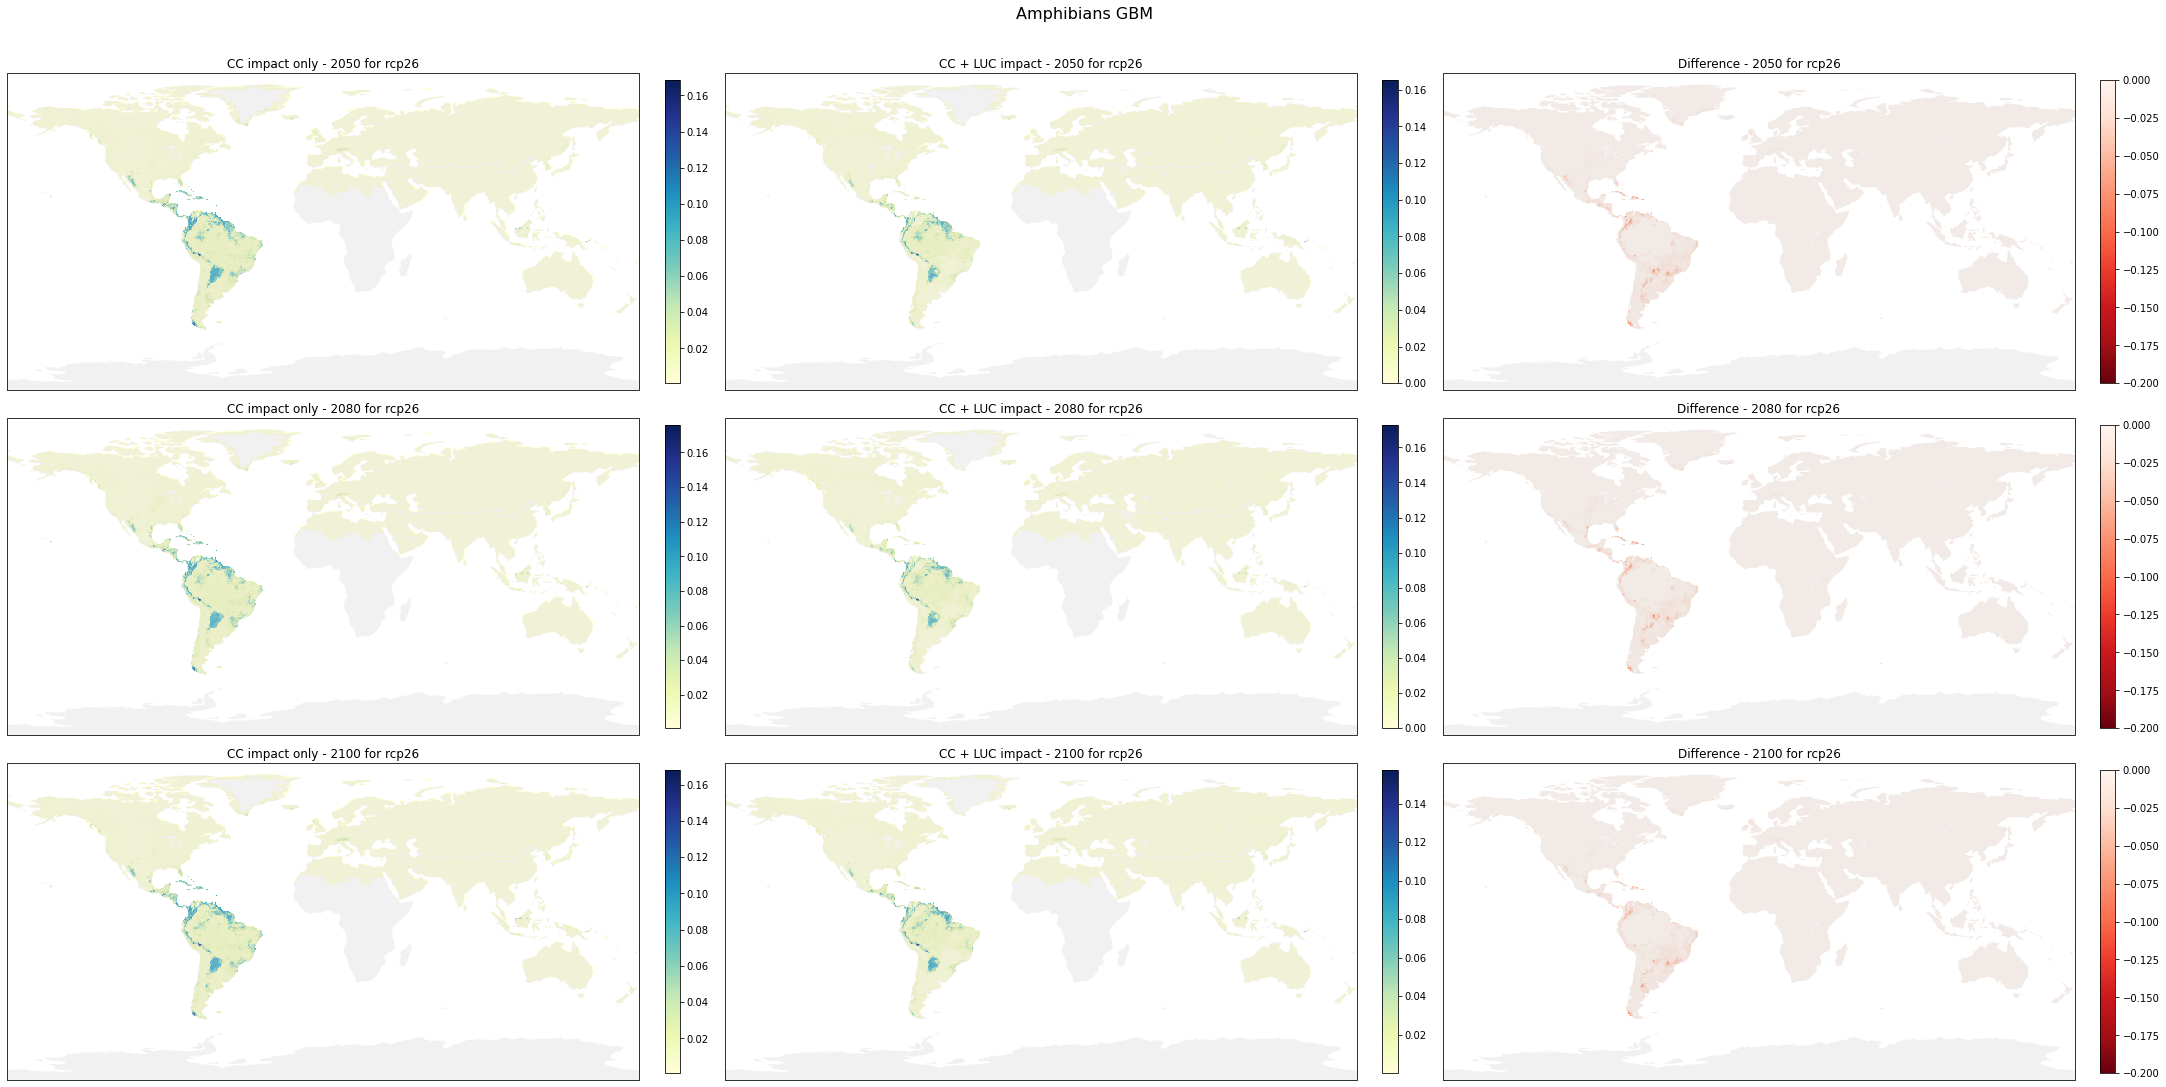

In [10]:
#### Comparison with vs without Land-use filter #### 
#one scenario at a time # 


models=["GBM"] 
taxas =["Amphibians"]

model_names = ['GFDL-ESM2M', 'IPSL-CM5A-LR', 'HadGEM2-ES', 'MIROC5']
#model_names = ['GFDL-ESM2M']

years= ['1845', '1990', '1995', '2009', '2010', '2020', '2026', '2032', '2048', '2050', 
                 '2052', '2056', '2080', '2100', '2150', '2200', '2250']

for taxa in taxas:
    for model in models:
        dir_species = "/storage/scratch/users/ch21o450/data/LandClim_Output/" + model + "/" + taxa + "/EWEMBI/"
        available_file = os.listdir(dir_species)
        available_names = [x.split("_[1146].nc")[0] for x in available_file]


species_names = available_names[:10]

#newvalue
for taxa in taxas:
    for model in models:
        def newvalue_fun(time, model, netcdf_path_format, is_historical=False, scenario=None):
            newvalue_dict = {model_name: {} for model_name in model_names}
            sum_bin_dict = {model_name: {} for model_name in model_names}

            for model_name in model_names:
                for species_name in species_names:
                    ds = xr.open_dataset(netcdf_path_format.format(model, taxa, model_name, scenario, species_name, time), decode_times=False)
                    newvalue = ds["newvalue"]
                    sum_bin = ds["sum_bin"]

                    newvalue_dict[model_name][species_name] = newvalue
                    sum_bin_dict[model_name][species_name] = sum_bin

            projections_dict = {}

            for species_name in species_names:
                value_list = []
                for model_name in model_names:
                    value_bin = newvalue_dict[model_name][species_name]
                    value_list.append(value_bin)
                value_bin_concat = xr.concat(value_list, dim="model")
                mean_value_bin = value_bin_concat.mean(dim="model")
                projections_dict[species_name] = mean_value_bin

            value_bin_list = list(projections_dict.values())
            mean_value_bin = xr.concat(value_bin_list, dim="species").mean(dim="species")

            return mean_value_bin
        
        def calculate_mean(time, model, netcdf_path_format, is_historical=False, scenario=None):
            newvalue_dict = {model_name: {} for model_name in model_names}
            sum_bin_dict = {model_name: {} for model_name in model_names}

            for model_name in model_names:
                for species_name in species_names:
                    if is_historical:
                        ds = xr.open_dataset(netcdf_path_format.format(model, taxa, species_name, time), decode_times=False)
                    else:
                        ds = xr.open_dataset(netcdf_path_format.format(model, taxa, model_name, scenario, species_name, time), decode_times=False)
                    sum_bin = ds["sum_bin"]
                    sum_bin_dict[model_name][species_name] = sum_bin

            projections_dict = {}


            for species_name in species_names:
                sum_bin_list = []
                for model_name in model_names:
                    sum_bin = sum_bin_dict[model_name][species_name]
                    sum_bin_list.append(sum_bin)
                sum_bin_concat = xr.concat(sum_bin_list, dim="model")
                mean_sum_bin = sum_bin_concat.mean(dim="model")
                projections_dict[species_name] = mean_sum_bin

            mean_sum_bin_list = list(projections_dict.values())
            mean_sum_bin = xr.concat(mean_sum_bin_list, dim="species").mean(dim="species")

            return mean_sum_bin
        

        future_times = [35, 65, 85]
        scenarios = ["rcp26"]

        netcdf_path_format_future = "/storage/scratch/users/ch21o450/data/LandClim_Output/{}/{}/{}/{}/{}_[{}].nc"


        fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(30, 26), subplot_kw={'projection': ccrs.PlateCarree()}, layout="compressed")


        cmap = matplotlib.colors.ListedColormap(['white', 'green'])
        countries = gpd.read_file(
                      gpd.datasets.get_path("naturalearth_lowres"))

        plot_idx = 0
        year_indices = {1146: '1995', 35: '2050', 65: '2080', 85: '2100'}

        for future_time in future_times:
            if future_time == 35 or future_time == 65:
                model_names = ['GFDL-ESM2M', 'IPSL-CM5A-LR', 'HadGEM2-ES', 'MIROC5']
                scenarios = ["rcp26"]
            elif future_time == 85:
                model_names = ['IPSL-CM5A-LR', 'HadGEM2-ES', 'MIROC5']
                scenarios = ["rcp26"]
            for scenario in scenarios:
                if future_time == 85 and scenario == "rcp60":
                    continue
        #for future_time in future_times:
         #   if future_time == 35 or future_time == 65:
          #      model_names = ['GFDL-ESM2M', 'IPSL-CM5A-LR', 'HadGEM2-ES', 'MIROC5']
           #     scenarios = ["rcp26"]
            #elif future_time == 85:
             #   model_names = ['IPSL-CM5A-LR', 'HadGEM2-ES', 'MIROC5']
              #  scenarios = ["rcp26"]

            #for scenario in scenarios:
             #   if future_time == 85 and scenario == "rcp60":
              #      continue

                # Call both functions and unpack their return values
                mean_value_bin = newvalue_fun(future_time, model, netcdf_path_format_future, is_historical=False, scenario=scenario)
                mean_sum_bin =  calculate_mean(future_time, model, netcdf_path_format_future, is_historical=False, scenario=scenario)
                mean_sum_bin = mean_sum_bin.isel(time=0)

                # Calculate the difference between the two
                diff_bin = mean_sum_bin -mean_value_bin

                # Create three subplots for each future time and scenario
                if plot_idx >= len(axes.flatten()):
                    break
                ax1 = axes.flatten()[plot_idx]
                ax2 = axes.flatten()[plot_idx + 1]
                ax3 = axes.flatten()[plot_idx + 2]

                # Plot newvalue_bin in the left subplot
                im1 = ax1.pcolormesh(mean_value_bin['lon'].values, mean_value_bin['lat'].values, np.where(mean_value_bin.values > 0, mean_value_bin.values, np.nan), transform=ccrs.PlateCarree(), cmap="YlGnBu")
                countries.plot(ax=ax1, color="lightgray", zorder=1, alpha=0.3)
                ax1.set_title(f"CC impact only - {year_indices[future_time]} for {scenario}")
                cbar1 = plt.colorbar(im1, ax=ax1, fraction=0.024, pad=0.04)

                # Plot sum_bin in the middle subplot
                im2 = ax2.pcolormesh(mean_sum_bin['lon'].values, mean_sum_bin['lat'].values,  np.where(mean_sum_bin.values > 0, mean_sum_bin.values, np.nan), transform=ccrs.PlateCarree(), cmap="YlGnBu")
                countries.plot(ax=ax2, color="lightgray", zorder=1, alpha=0.3)
                ax2.set_title(f"CC + LUC impact - {year_indices[future_time]} for {scenario}")
                cbar2 = plt.colorbar(im2, ax=ax2, fraction=0.024, pad=0.04)

                # Plot diff_bin in the right subplot
                im3 = ax3.pcolormesh(diff_bin['lon'].values, diff_bin['lat'].values, diff_bin.values, transform=ccrs.PlateCarree(), cmap="Reds_r", vmin=-0.2, vmax=0)
                countries.plot(ax=ax3, color="lightgray", zorder=1, alpha=0.3)
                ax3.set_title(f"Difference - {year_indices[future_time]} for {scenario}")
                cbar3 = plt.colorbar(im3, ax=ax3, fraction=0.024, pad=0.04)
                
                

                # Increase the plot index by 3 to move to the next triplet of subplots
                plot_idx += 3


        #plt.tight_layout()
        plt.suptitle(taxa+ " " + model, size=16, y=0.8)
        plt.show()


In [24]:
#### Comparison with vs without Land-use filter #### 
#one scenario at a time # 


models=["GAM"] 
taxas =["Mammals"]

model_names = ['GFDL-ESM2M', 'IPSL-CM5A-LR', 'HadGEM2-ES', 'MIROC5']
#model_names = ['GFDL-ESM2M']

years= ['1845', '1990', '1995', '2009', '2010', '2020', '2026', '2032', '2048', '2050', 
                 '2052', '2056', '2080', '2100', '2150', '2200', '2250']

for taxa in taxas:
    for model in models:
        dir_species = "/storage/scratch/users/ch21o450/data/LandClim_Output/" + model + "/" + taxa + "/EWEMBI/"
        available_file = os.listdir(dir_species)
        available_names = [x.split("_[1146].nc")[0] for x in available_file]


        species_names = available_names[:50]

   
        def newvalue_fun(time, model, model_names,netcdf_path_format, is_historical=False, scenario=None):
            newvalue_dict = {model: {model_name: {} for model_name in model_names} for model in models}
            sum_bin_dict = {model: {model_name: {} for model_name in model_names} for model in models}
            
            for model in models:
                for model_name in model_names:
                    for species_name in species_names:
                        ds = xr.open_dataset(netcdf_path_format.format(model, taxa, model_name, scenario, species_name, time), decode_times=False)
                        newvalue = ds["newvalue"]
                        sum_bin = ds["sum_bin"]

                        newvalue_dict[model][model_name][species_name] = newvalue
                        sum_bin_dict[model][model_name][species_name] = sum_bin

                projections_dict = {}

            for species_name in species_names:
                value_list = []
                for model in models:
                    for model_name in model_names:
                        value_bin = newvalue_dict[model][model_name][species_name]
                        value_list.append(value_bin)
                value_bin_concat = xr.concat(value_list, dim="model")
                mean_value_bin = value_bin_concat.mean(dim="model")
                projections_dict[species_name] = mean_value_bin

            value_bin_list = list(projections_dict.values())
            mean_value_bin = xr.concat(value_bin_list, dim="species").mean(dim="species")

            return mean_value_bin


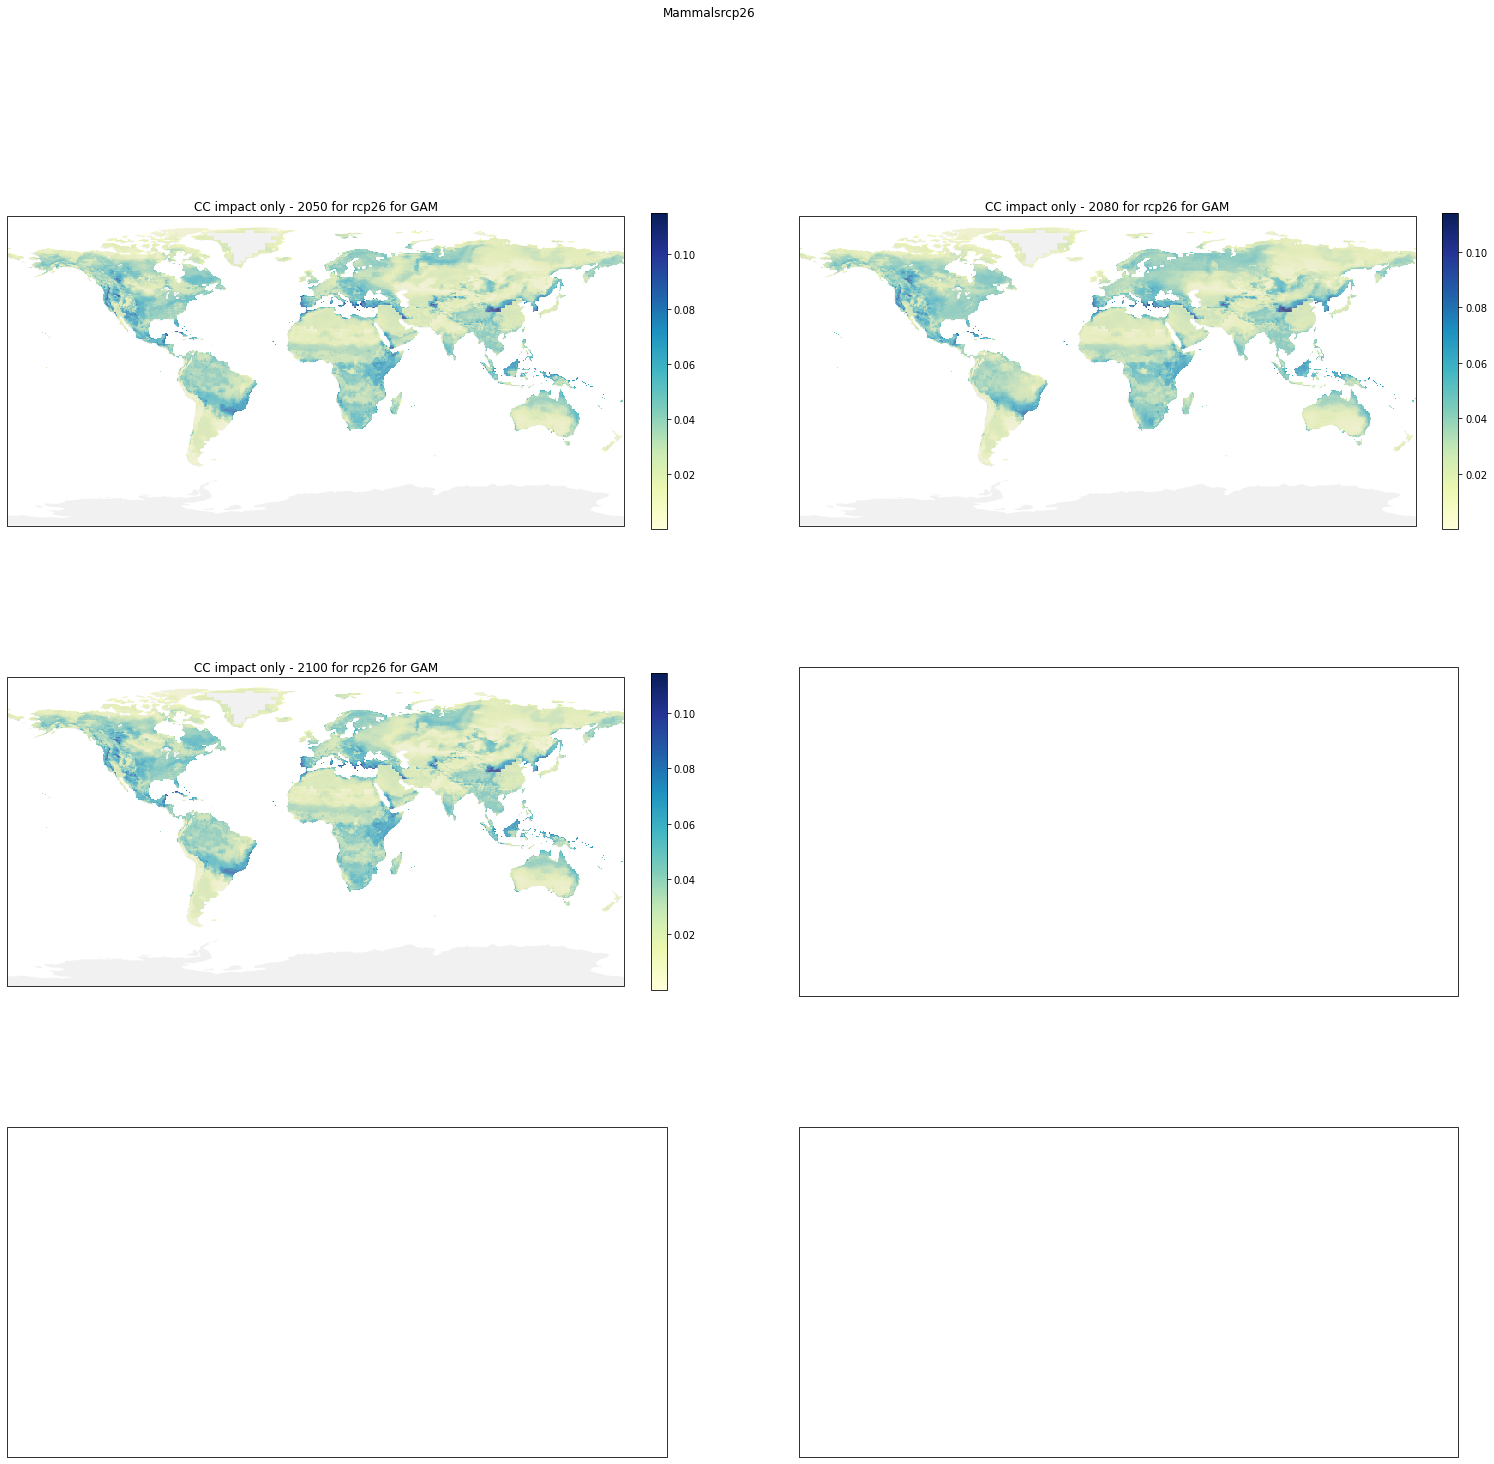

In [25]:


future_times = [35, 65, 85]
scenarios = ["rcp26"]

netcdf_path_format_future = "/storage/scratch/users/ch21o450/data/LandClim_Output/{}/{}/{}/{}/{}_[{}].nc"


fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(26, 24), subplot_kw={'projection': ccrs.PlateCarree()})


cmap = matplotlib.colors.ListedColormap(['white', 'green'])
countries = gpd.read_file(
              gpd.datasets.get_path("naturalearth_lowres"))

plot_idx = 0
year_indices = {1146: '1995', 35: '2050', 65: '2080', 85: '2100'}

for future_time in future_times:
    if future_time == 35 or future_time == 65:
        model_names = ['GFDL-ESM2M', 'IPSL-CM5A-LR', 'HadGEM2-ES', 'MIROC5']
        scenarios = ["rcp26"]
    elif future_time == 85:
        model_names = ['IPSL-CM5A-LR', 'HadGEM2-ES', 'MIROC5']
        scenarios = ["rcp26"]
    for scenario in scenarios:
        if future_time == 85 and scenario == "rcp60":
            continue
    for taxa in taxas:
        # Call both functions and unpack their return values
        mean_value_bin_gam = newvalue_fun(future_time, ["GAM"], model_names, netcdf_path_format_future, is_historical=False, scenario=scenario)
        #mean_value_bin_gbm = newvalue_fun(future_time, ["GBM"], model_names, netcdf_path_format_future, is_historical=False, scenario=scenario)
        # Calculate the difference between the two
        # diff_bin = mean_sum_bin -mean_value_bin

        # Create three subplots for each future time and scenario
        if plot_idx >= len(axes.flatten()):
            break
        ax1 = axes.flatten()[plot_idx]
        #ax2 = axes.flatten()[plot_idx + 1]

        # Plot newvalue_bin in the left subplot
        im1 = ax1.pcolormesh(mean_value_bin_gam['lon'].values, mean_value_bin_gam['lat'].values, np.where(mean_value_bin_gam.values > 0, mean_value_bin_gam.values, np.nan), transform=ccrs.PlateCarree(), cmap="YlGnBu")
        countries.plot(ax=ax1, color="lightgray", zorder=1, alpha=0.3)
        ax1.set_title(f"CC impact only - {year_indices[future_time]} for {scenario} for GAM")
        cbar1 = plt.colorbar(im1, ax=ax1, fraction=0.024, pad=0.04)




        # Increase the plot index by 2 to move to the next pair of subplots
        plt.suptitle(taxa + "rcp26")
        plot_idx += 1

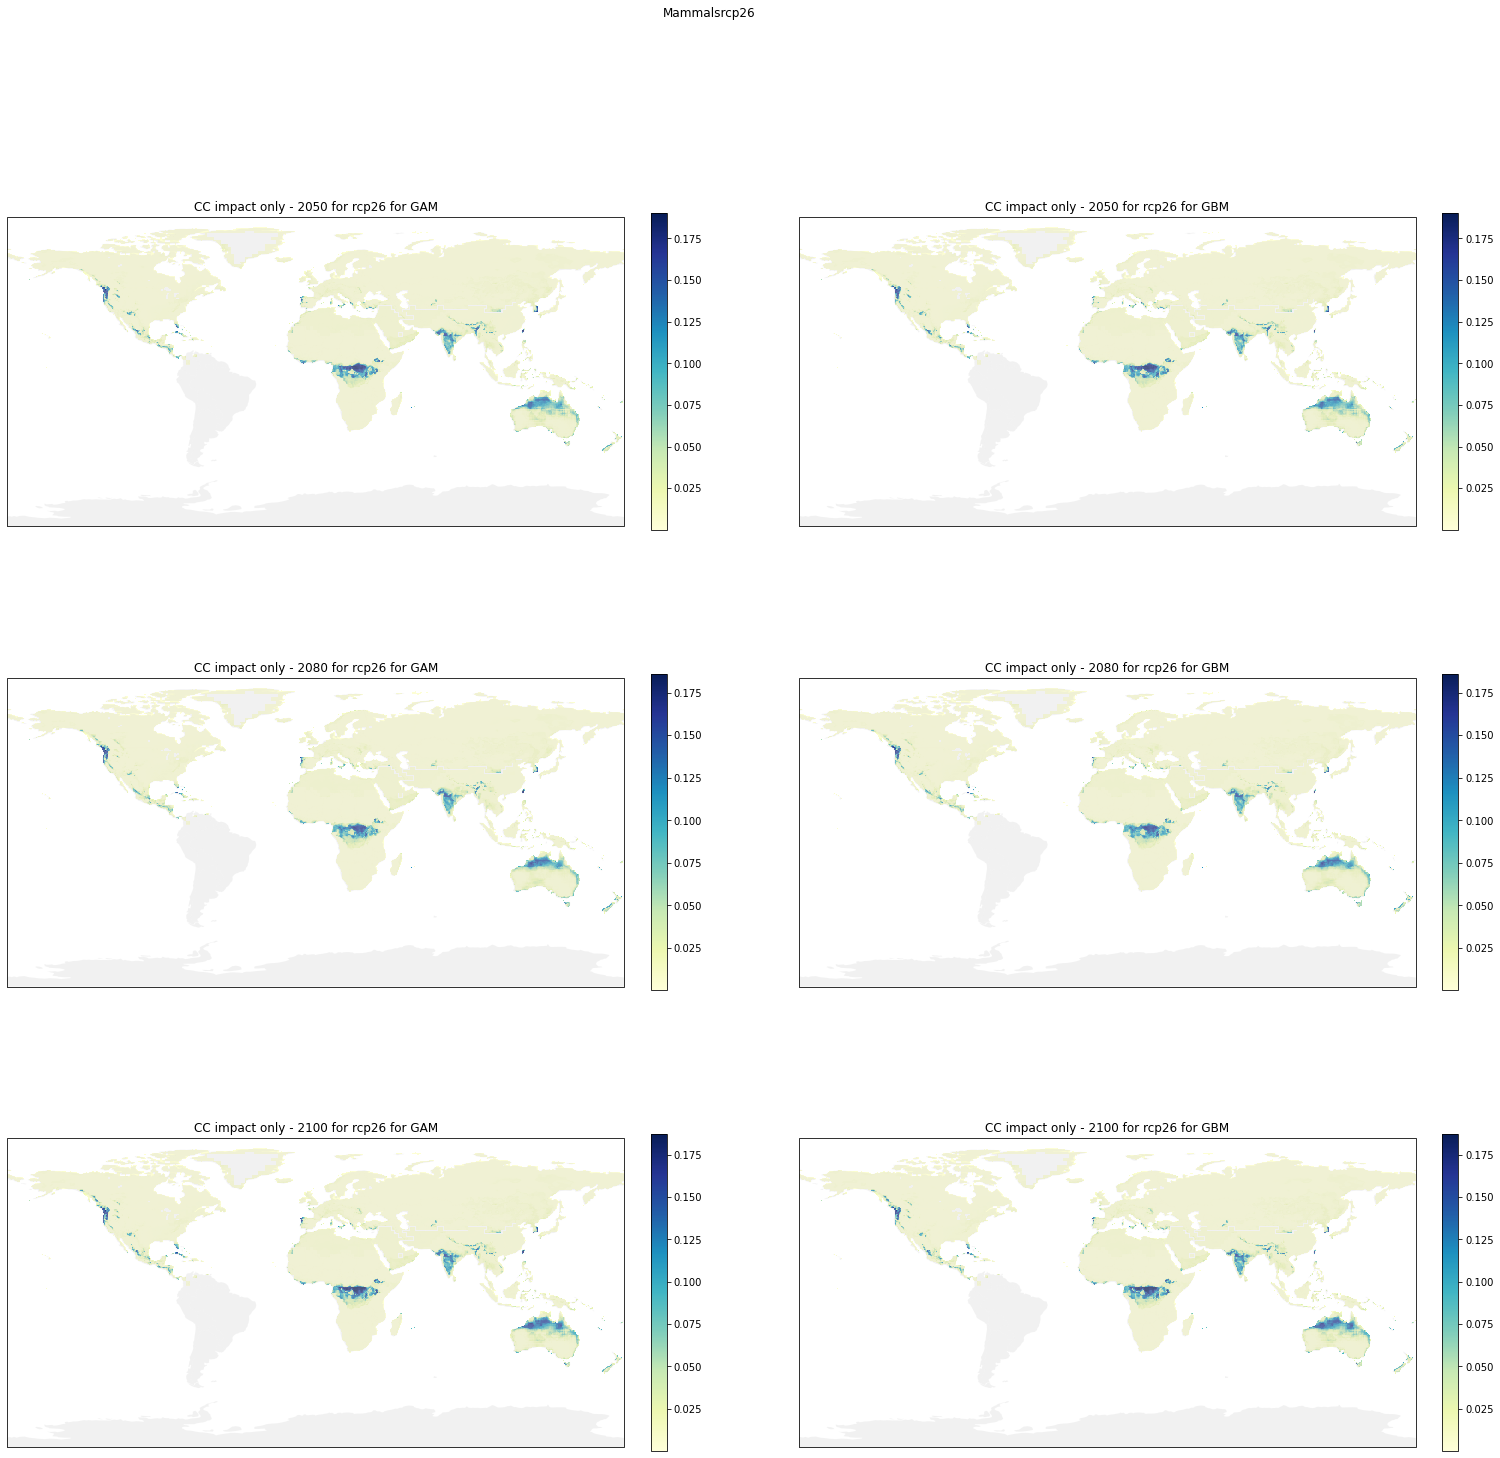

In [23]:


future_times = [35, 65, 85]
scenarios = ["rcp26"]

netcdf_path_format_future = "/storage/scratch/users/ch21o450/data/LandClim_Output/{}/{}/{}/{}/{}_[{}].nc"


fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(26, 24), subplot_kw={'projection': ccrs.PlateCarree()})


cmap = matplotlib.colors.ListedColormap(['white', 'green'])
countries = gpd.read_file(
              gpd.datasets.get_path("naturalearth_lowres"))

plot_idx = 0
year_indices = {1146: '1995', 35: '2050', 65: '2080', 85: '2100'}

for future_time in future_times:
    if future_time == 35 or future_time == 65:
        model_names = ['GFDL-ESM2M', 'IPSL-CM5A-LR', 'HadGEM2-ES', 'MIROC5']
        scenarios = ["rcp26"]
    elif future_time == 85:
        model_names = ['IPSL-CM5A-LR', 'HadGEM2-ES', 'MIROC5']
        scenarios = ["rcp26"]
    for scenario in scenarios:
        if future_time == 85 and scenario == "rcp60":
            continue
    for taxa in taxas:
        # Call both functions and unpack their return values
        mean_value_bin_gam = newvalue_fun(future_time, ["GAM"], model_names, netcdf_path_format_future, is_historical=False, scenario=scenario)
        mean_value_bin_gbm = newvalue_fun(future_time, ["GBM"], model_names, netcdf_path_format_future, is_historical=False, scenario=scenario)
        # Calculate the difference between the two
        # diff_bin = mean_sum_bin -mean_value_bin

        # Create three subplots for each future time and scenario
        if plot_idx >= len(axes.flatten()):
            break
        ax1 = axes.flatten()[plot_idx]
        ax2 = axes.flatten()[plot_idx + 1]

        # Plot newvalue_bin in the left subplot
        im1 = ax1.pcolormesh(mean_value_bin_gam['lon'].values, mean_value_bin_gam['lat'].values, np.where(mean_value_bin_gam.values > 0, mean_value_bin_gam.values, np.nan), transform=ccrs.PlateCarree(), cmap="YlGnBu")
        countries.plot(ax=ax1, color="lightgray", zorder=1, alpha=0.3)
        ax1.set_title(f"CC impact only - {year_indices[future_time]} for {scenario} for GAM")
        cbar1 = plt.colorbar(im1, ax=ax1, fraction=0.024, pad=0.04)

        # Plot sum_bin in the middle subplot
        im2 = ax2.pcolormesh(mean_value_bin_gbm['lon'].values, mean_value_bin_gbm['lat'].values,  np.where(mean_value_bin_gbm.values > 0, mean_value_bin_gbm.values, np.nan), transform=ccrs.PlateCarree(), cmap="YlGnBu")
        countries.plot(ax=ax2, color="lightgray", zorder=1, alpha=0.3)
        ax2.set_title(f"CC impact only - {year_indices[future_time]} for {scenario} for GBM")
        cbar2 = plt.colorbar(im2, ax=ax2, fraction=0.024, pad=0.04)                


        # Increase the plot index by 2 to move to the next pair of subplots
        plt.suptitle(taxa + "rcp26")
        plot_idx += 2

In [9]:
mean_value_bin_gam.mean()

<xarray.DataArray 'newvalue' ()>
array(0.00811722)

In [10]:
mean_value_bin_gbm.mean()

<xarray.DataArray 'newvalue' ()>
array(0.00811575)

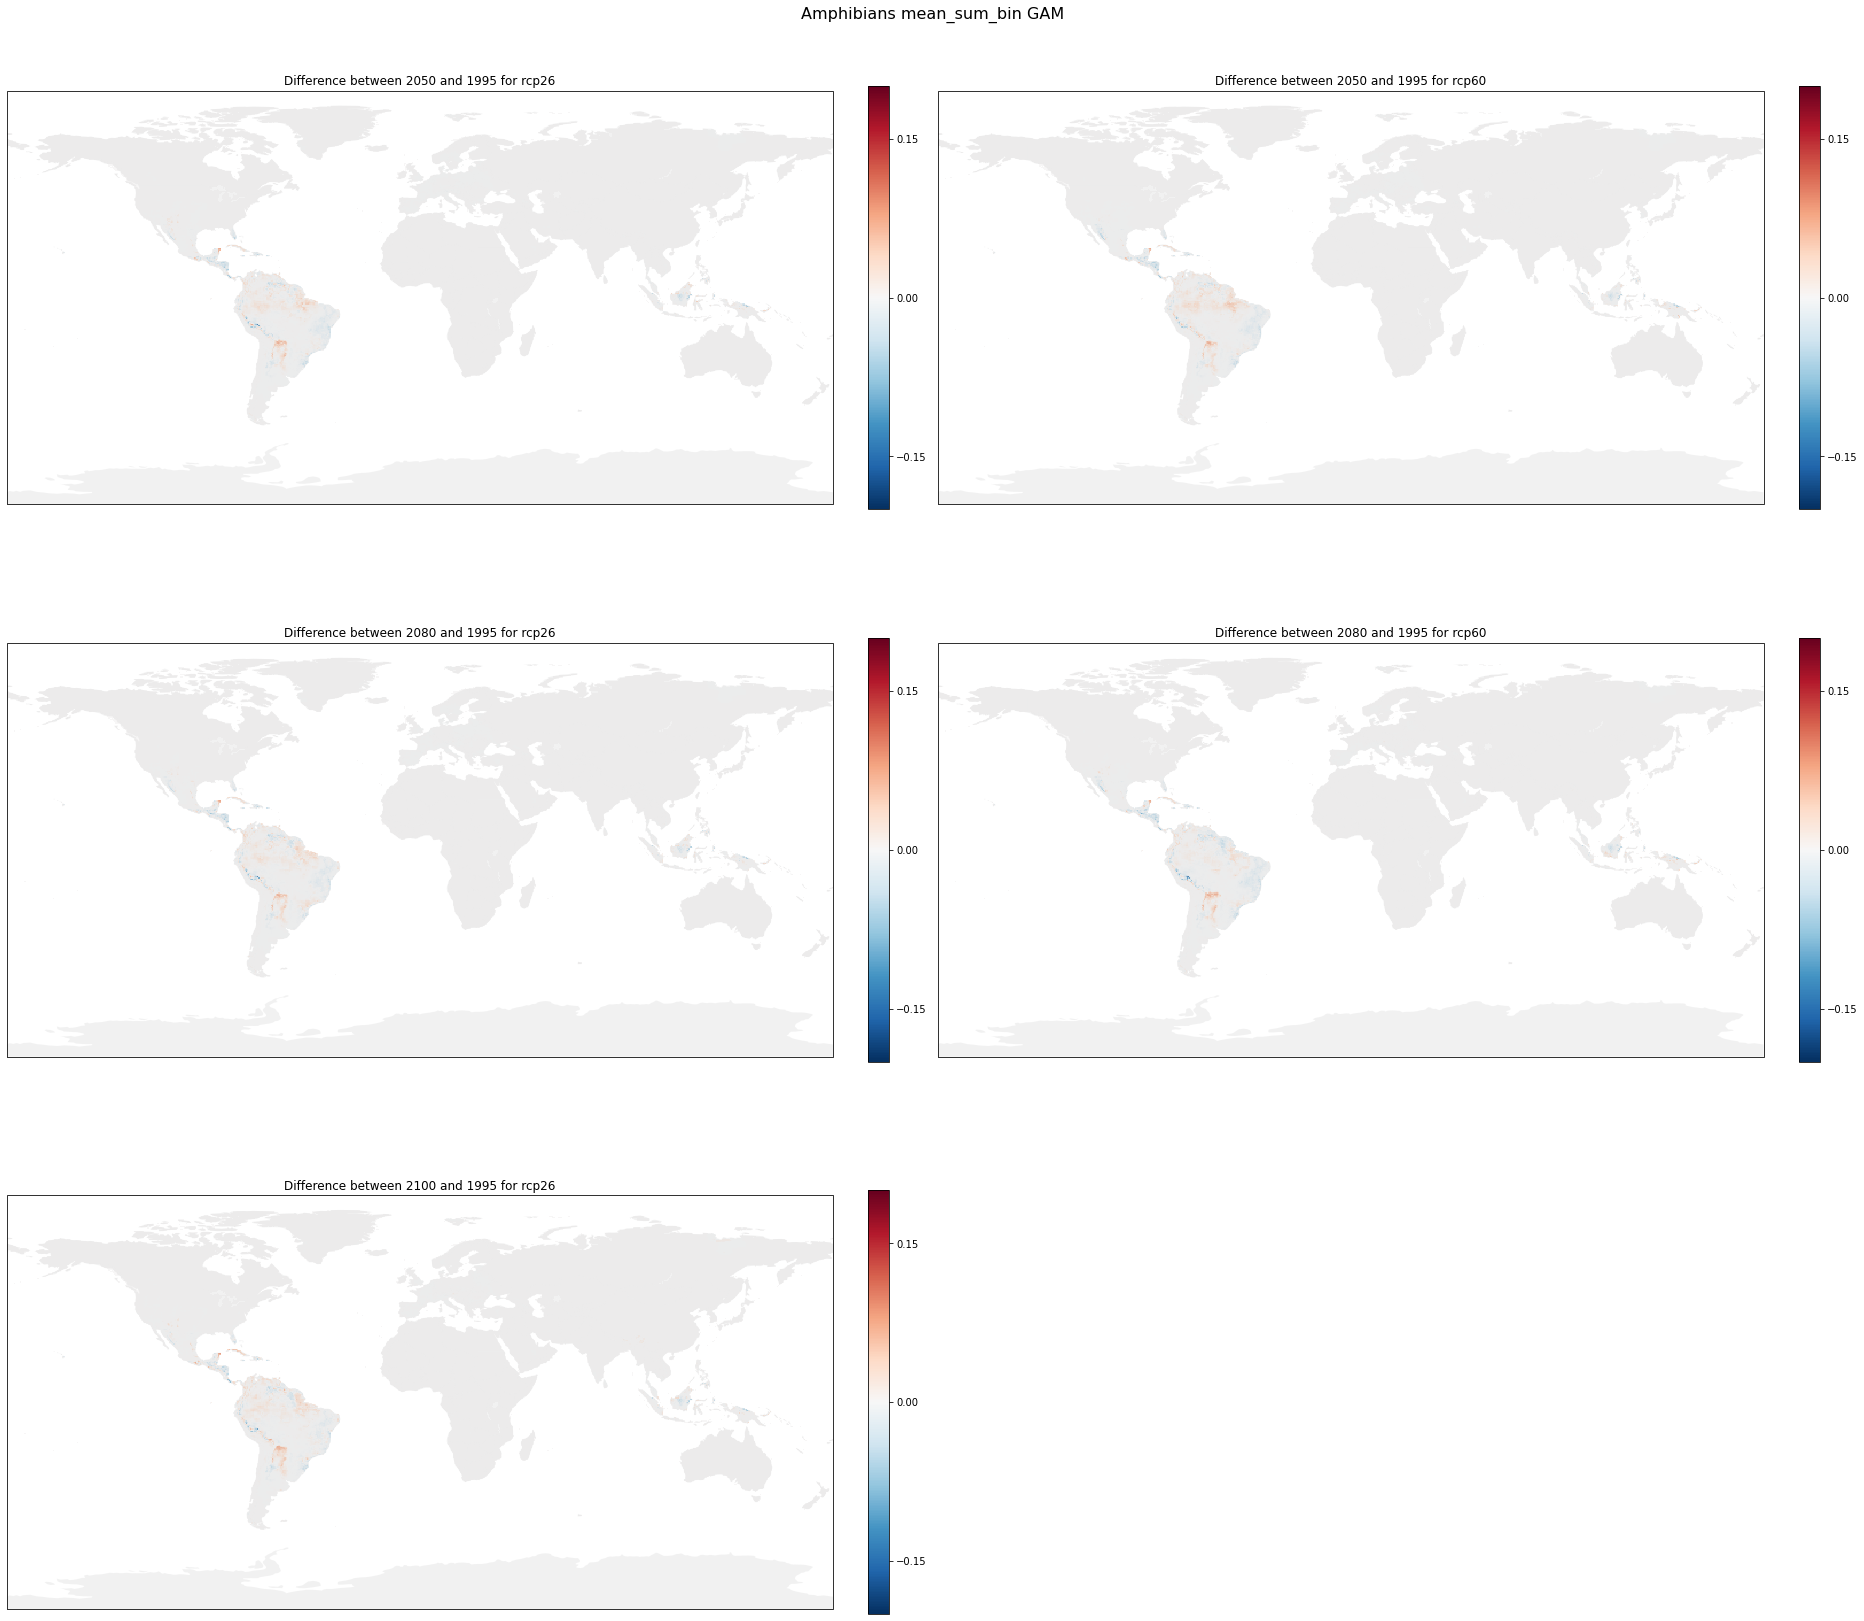

In [10]:
##### Difference future - past ##### 
##### LandClim results  ##### - SDM models seperate 

models=["GAM"] 
taxas =["Amphibians"]

model_names = ['GFDL-ESM2M', 'IPSL-CM5A-LR', 'HadGEM2-ES', 'MIROC5']

years= ['1845', '1990', '1995', '2009', '2010', '2020', '2026', '2032', '2048', '2050', 
                 '2052', '2056', '2080', '2100', '2150', '2200', '2250']

for taxa in taxas:
    for model in models:
        dir_species = "/storage/scratch/users/ch21o450/data/LandClim_Output/" + model + "/" + taxa + "/EWEMBI/"
        available_file = os.listdir(dir_species)
        available_names = [x.split("_[1146].nc")[0] for x in available_file]


species_names = available_names[:10]


for taxa in taxas:
    for model in models:
        def calculate_mean(time, model, netcdf_path_format, is_historical=False, scenario=None):
            newvalue_dict = {model_name: {} for model_name in model_names}
            sum_bin_dict = {model_name: {} for model_name in model_names}

            for model_name in model_names:
                for species_name in species_names:
                    if is_historical:
                        ds = xr.open_dataset(netcdf_path_format.format(model, taxa, species_name, time), decode_times=False)
                    else:
                        ds = xr.open_dataset(netcdf_path_format.format(model, taxa, model_name, scenario, species_name, time), decode_times=False)
                    sum_bin = ds["sum_bin"]
                    sum_bin_dict[model_name][species_name] = sum_bin

            projections_dict = {}


            for species_name in species_names:
                sum_bin_list = []
                for model_name in model_names:
                    sum_bin = sum_bin_dict[model_name][species_name]
                    sum_bin_list.append(sum_bin)
                sum_bin_concat = xr.concat(sum_bin_list, dim="model")
                mean_sum_bin = sum_bin_concat.mean(dim="model")
                projections_dict[species_name] = mean_sum_bin

            mean_sum_bin_list = list(projections_dict.values())
            mean_sum_bin = xr.concat(mean_sum_bin_list, dim="species").mean(dim="species")

            return mean_sum_bin

        #sum_bin
        historical_time = 1146
        future_times = [35, 65, 85]
        scenarios = ["rcp26", "rcp60"]
        model_names = ['GFDL-ESM2M', 'IPSL-CM5A-LR', 'HadGEM2-ES', 'MIROC5']
        netcdf_path_format_future = "/storage/scratch/users/ch21o450/data/LandClim_Output/{}/{}/{}/{}/{}_[{}].nc"
        netcdf_path_format_hist = "/storage/scratch/users/ch21o450/data/LandClim_Output/{}/{}/EWEMBI/{}_[{}].nc"

        mean_hist = calculate_mean(historical_time, model, netcdf_path_format_hist, is_historical=True)
        fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(26, 24), subplot_kw={'projection': ccrs.PlateCarree()})

        cmap = matplotlib.colors.ListedColormap(['white', 'green'])
        countries = gpd.read_file(
                      gpd.datasets.get_path("naturalearth_lowres"))

        plot_idx = 0
        year_indices = {1146: '1995', 35: '2050', 65: '2080', 85: '2100'}
        for future_time in future_times:
            if future_time == 35 or future_time == 65:
                model_names = ['GFDL-ESM2M', 'IPSL-CM5A-LR', 'HadGEM2-ES', 'MIROC5']
                scenarios = ["rcp26", "rcp60"]
            elif future_time == 85:
                model_names = ['IPSL-CM5A-LR', 'HadGEM2-ES', 'MIROC5']
                scenarios = ["rcp26"]

            for scenario in scenarios:
                if future_time == 85 and scenario == "rcp60":
                    continue


                mean_future = calculate_mean(future_time, model, netcdf_path_format_future, is_historical=False, scenario=scenario)

                # Select the 0th time slice in mean_future and mean_hist data arrays
                mean_future_slice = mean_future.isel(time=0)
                mean_hist_slice = mean_hist.isel(time=0)

                difference = mean_future_slice - mean_hist_slice
                ax = axes.flatten()[plot_idx]
                im = difference.plot(ax=ax, transform=ccrs.PlateCarree(), cmap="RdBu_r", add_colorbar=False, vmin=-0.2, vmax=0.2)

                countries.plot(ax=ax, color="lightgray", zorder=1, alpha=0.3)
                ax.set_title(f"Difference between {year_indices[future_time]} and {year_indices[historical_time]} for {scenario}")

                cbar = plt.colorbar(im, ax=ax, fraction=0.024, pad=0.04)
                cbar.set_ticks([-0.15, 0, 0.15])

                plot_idx += 1

        # Hide the last (empty) subplot
        axes.flatten()[-1].set_visible(False)
        plt.suptitle('Amphibians mean_sum_bin GAM', size=16)

        plt.tight_layout()
        plt.show()


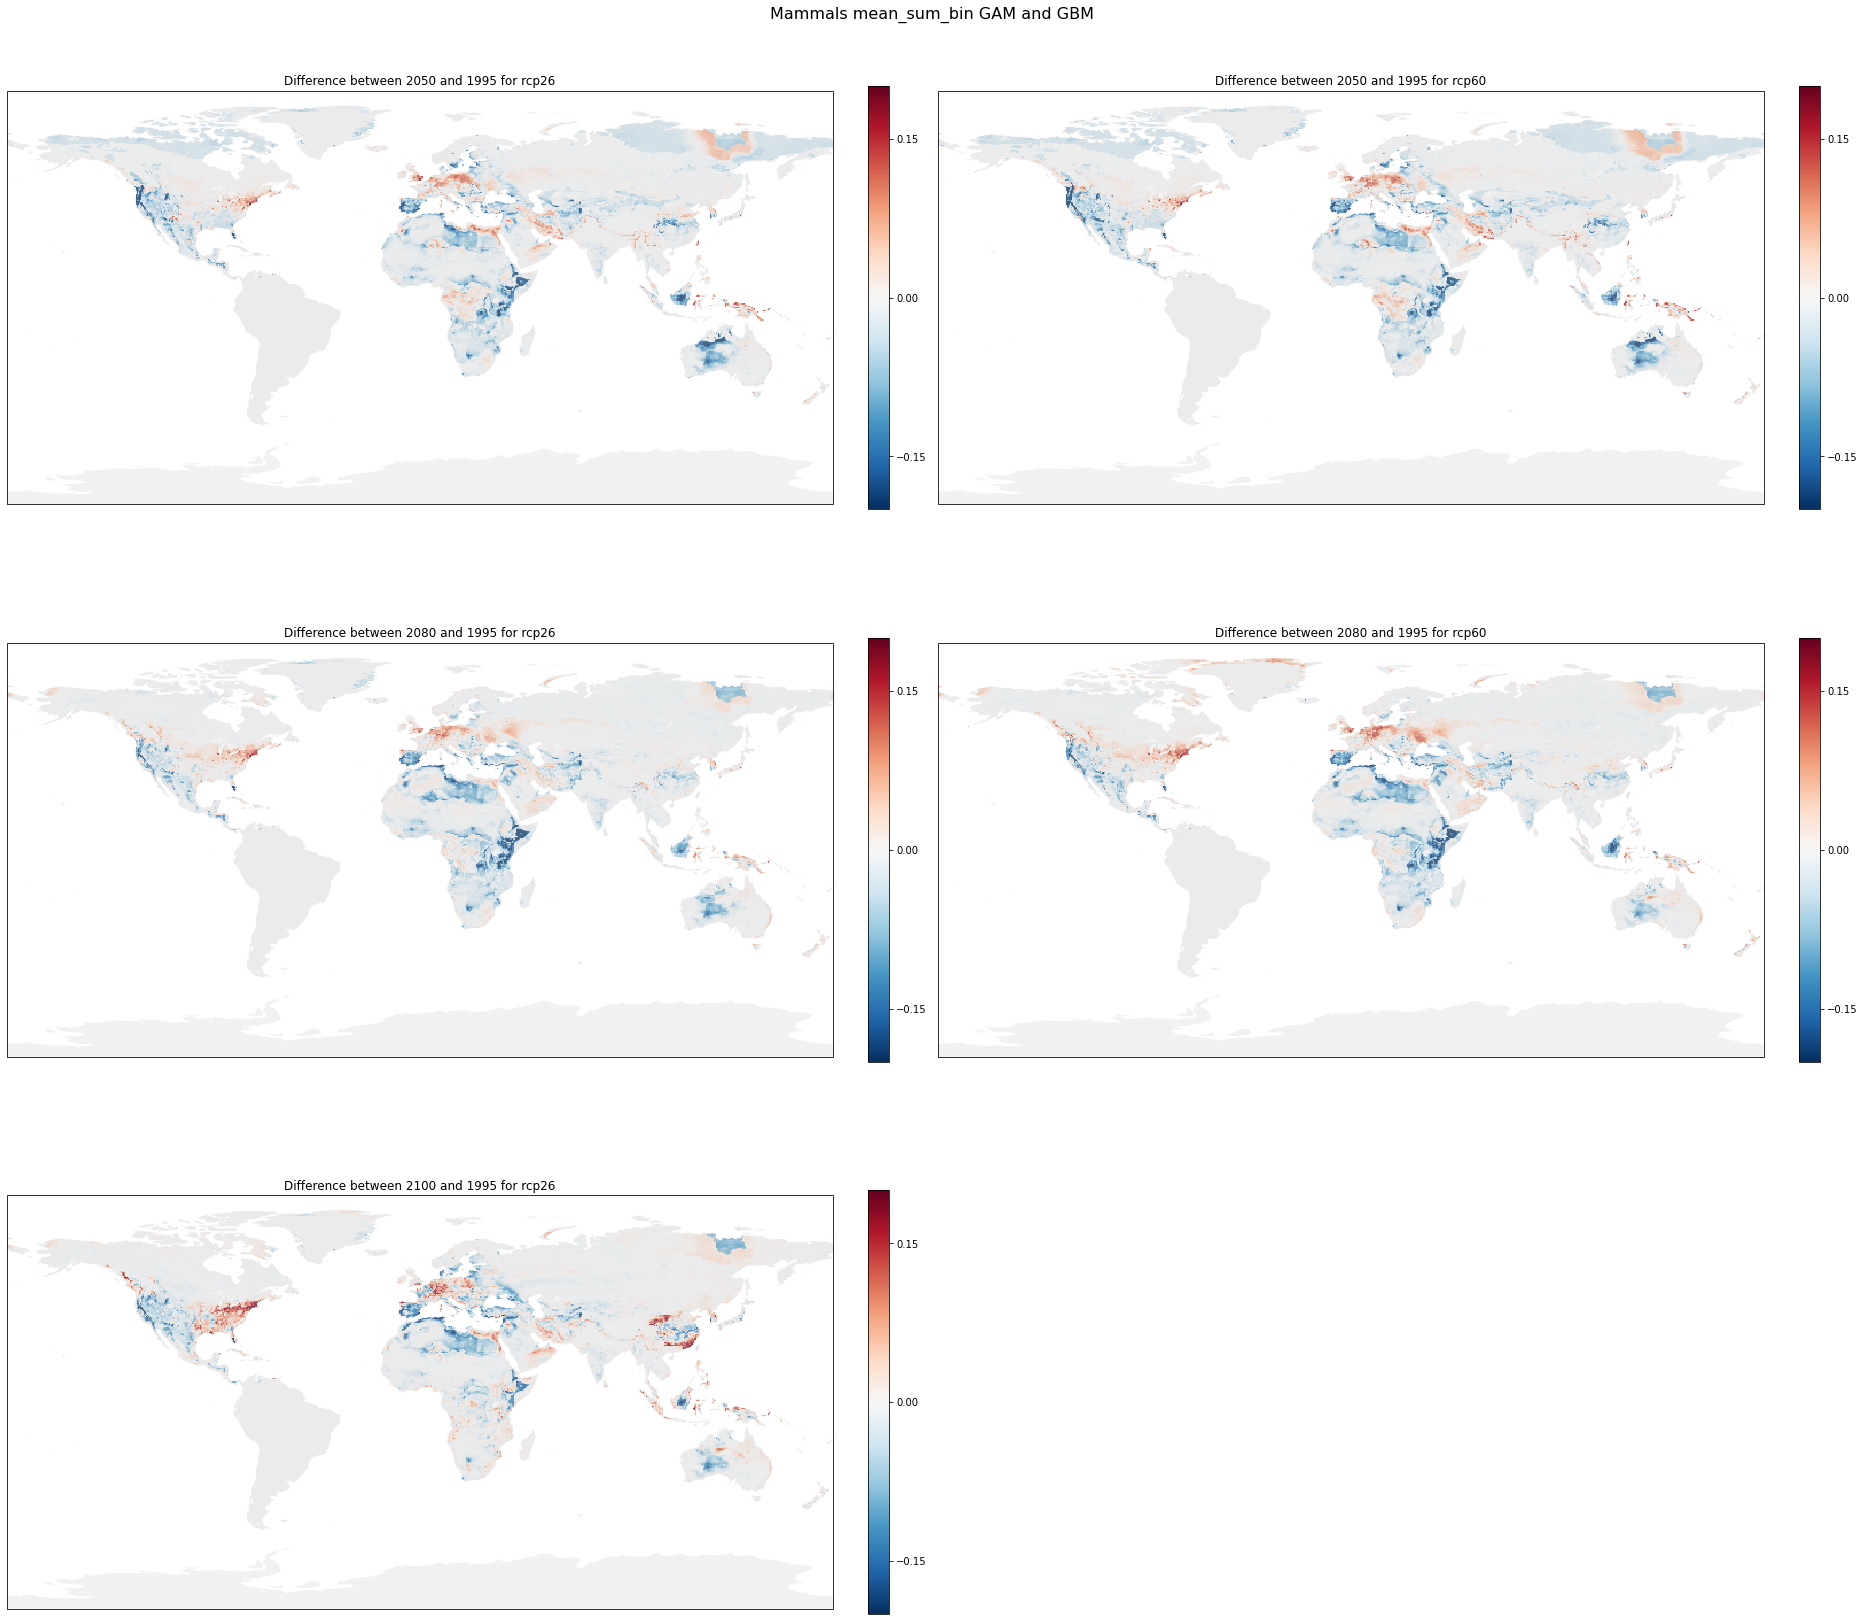

In [63]:
#### LandClim SDM ensemble #### 

models=["GAM", "GBM"]
taxas=["Mammals"]

model_names = ['GFDL-ESM2M', 'IPSL-CM5A-LR', 'HadGEM2-ES', 'MIROC5']

years= ['1845', '1990', '1995', '2009', '2010', '2020', '2026', '2032', '2048', '2050', 
                 '2052', '2056', '2080', '2100', '2150', '2200', '2250']

for taxa in taxas:# Get all possible combinations of models and model_names    
    for model in models :
                
                
        dir_species = "/storage/scratch/users/ch21o450/data/LandClim_Output/" + model + "/" +taxa+ "/EWEMBI/"
        available_file = os.listdir(dir_species)
        available_names = [x.split("_[1146].nc")[0] for x in available_file]


        species_names = available_names[:10]


        def calculate_model_mean(time, models, model_names, netcdf_path_format, is_historical=False, scenario=None):
            sum_bin_dict = {model: {model_name: {} for model_name in model_names} for model in models}

            for model in models:
                for model_name in model_names:
                    for species_name in species_names:
                        if is_historical:
                            ds = xr.open_dataset(netcdf_path_format.format(model, taxa,  species_name, time), decode_times=False)
                        else:
                            ds = xr.open_dataset(netcdf_path_format.format(model,taxa, model_name, scenario, species_name, time), decode_times=False)
                        sum_bin = ds["sum_bin"]
                        sum_bin_dict[model][model_name][species_name] = sum_bin

            projections_dict = {}

            for species_name in species_names:
                sum_bin_list = []
                for model in models:
                    for model_name in model_names:
                        sum_bin = sum_bin_dict[model][model_name][species_name]
                        sum_bin_list.append(sum_bin)
                sum_bin_concat = xr.concat(sum_bin_list, dim="model")
                mean_sum_bin = sum_bin_concat.mean(dim="model")
                projections_dict[species_name] = mean_sum_bin

            mean_sum_bin_list = list(projections_dict.values())
            mean_sum_bin = xr.concat(mean_sum_bin_list, dim="species").mean(dim="species")

            return mean_sum_bin

    historical_time = 1146
    future_times = [35, 65, 85]
    scenarios = ["rcp26", "rcp60"]
    model_names = ['GFDL-ESM2M', 'IPSL-CM5A-LR', 'HadGEM2-ES', 'MIROC5']
    netcdf_path_format_future = "/storage/scratch/users/ch21o450/data/LandClim_Output/{}/{}/{}/{}/{}_[{}].nc"
    netcdf_path_format_hist = "/storage/scratch/users/ch21o450/data/LandClim_Output/{}/{}/EWEMBI/{}_[{}].nc"

    mean_hist_gam = calculate_model_mean(historical_time, ["GAM"], model_names, netcdf_path_format_hist, is_historical=True)
    mean_hist_gbm = calculate_model_mean(historical_time, ["GBM"], model_names, netcdf_path_format_hist, is_historical=True)
    mean_hist = (mean_hist_gam + mean_hist_gbm) / 2

    fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(26, 24), subplot_kw={'projection': ccrs.PlateCarree()})
    cmap = matplotlib.colors.ListedColormap(['white', 'green'])
    countries = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))

    plot_idx = 0
    year_indices = {1146: '1995', 35: '2050', 65: '2080', 85: '2100'}
    
    for future_time in future_times:
        if future_time == 35 or future_time == 65:
            model_names = ['GFDL-ESM2M', 'IPSL-CM5A-LR', 'HadGEM2-ES', 'MIROC5']
            scenarios = ["rcp26", "rcp60"]
        elif future_time == 85:
            model_names = ['IPSL-CM5A-LR', 'HadGEM2-ES', 'MIROC5']
            scenarios = ["rcp26"]

        for scenario in scenarios:
            if future_time == 85 and scenario == "rcp60":
                continue

            mean_future_gam = calculate_model_mean(future_time, ["GAM"], model_names, netcdf_path_format_future, is_historical=False, scenario=scenario)
            mean_future_gbm = calculate_model_mean(future_time, ["GBM"], model_names, netcdf_path_format_future, is_historical=False, scenario=scenario)
            mean_future = (mean_future_gam + mean_future_gbm) /2

    # Select the 0th time slice in mean_future and mean_hist data arrays
            mean_future_slice = mean_future.isel(time=0)
            mean_hist_slice = mean_hist.isel(time=0)

            difference = mean_future_slice - mean_hist_slice
            ax = axes.flatten()[plot_idx]
            im = difference.plot(ax=ax, transform=ccrs.PlateCarree(), cmap="RdBu_r", add_colorbar=False, vmin=-0.2, vmax=0.2)

            countries.plot(ax=ax, color="lightgray", zorder=1, alpha=0.3)
            ax.set_title(f"Difference between {year_indices[future_time]} and {year_indices[historical_time]} for {scenario}")

            cbar = plt.colorbar(im, ax=ax, fraction=0.024, pad=0.04)
            cbar.set_ticks([-0.15, 0, 0.15])

            plot_idx += 1

        # Hide the last (empty) subplot
    axes.flatten()[-1].set_visible(False)
    plt.suptitle(taxa+ ' mean_sum_bin GAM and GBM', size=16)

    plt.tight_layout()
    plt.show()


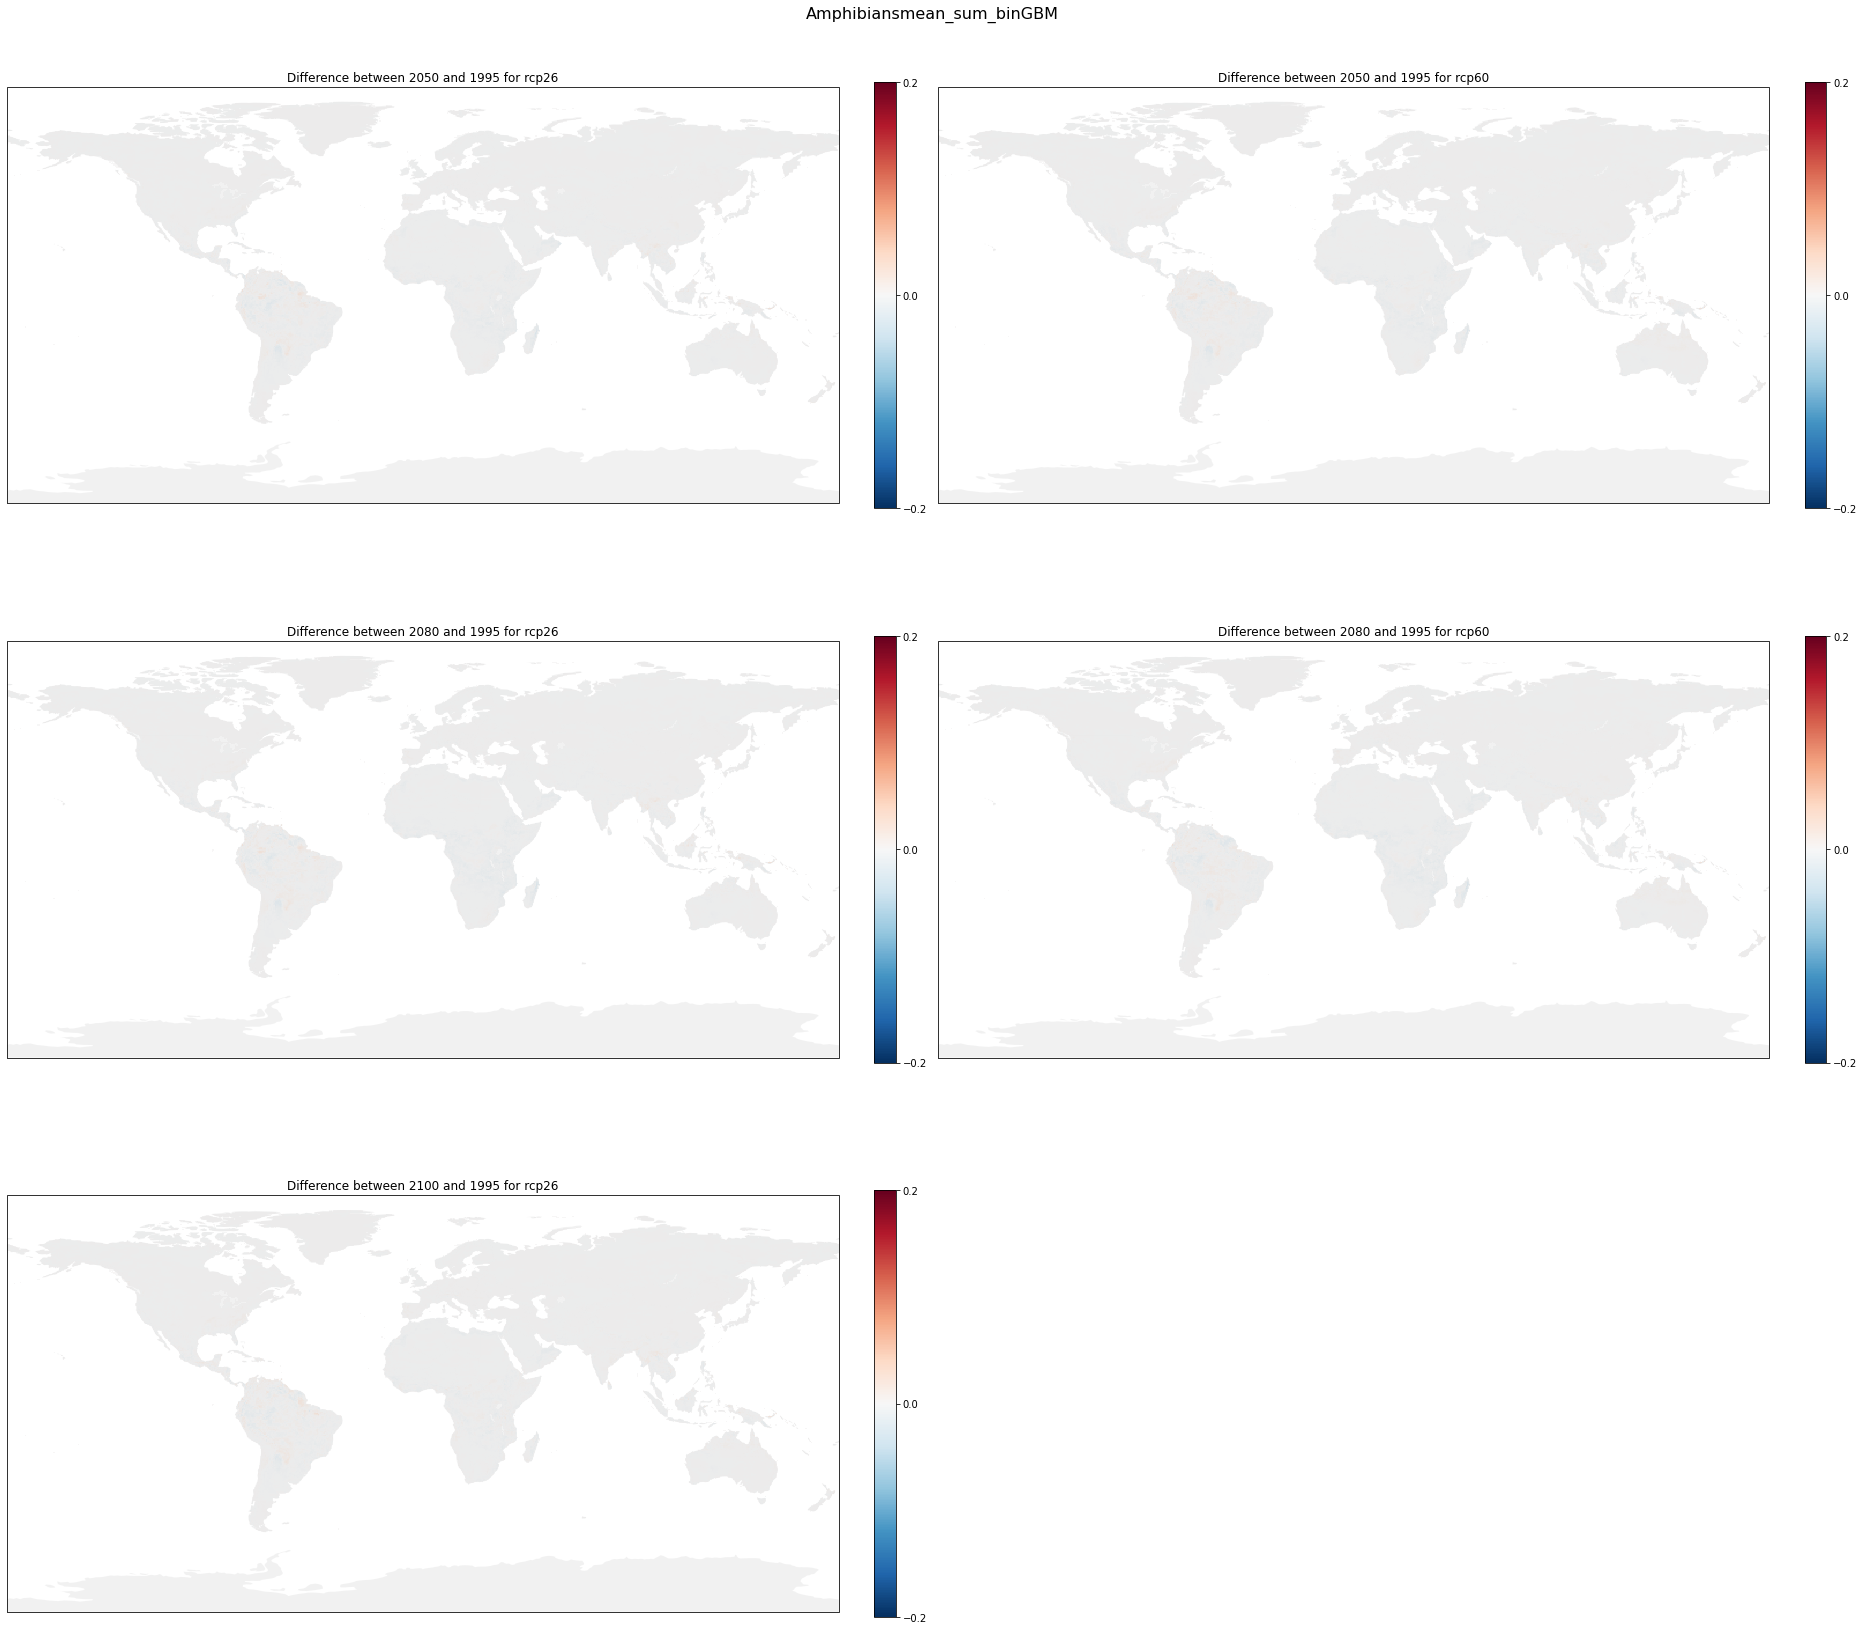

In [41]:
#### species richness SDM seperate #### 



model_names = ['GFDL-ESM2M', 'IPSL-CM5A-LR', 'HadGEM2-ES', 'MIROC5']

years= ['1845', '1990', '1995', '2009', '2010', '2020', '2026', '2032', '2048', '2050', 
                 '2052', '2056', '2080', '2100', '2150', '2200', '2250']

for taxa in taxas:# Get all possible combinations of models and model_names    
    for model in models :
                
                
        dir_species = "/storage/scratch/users/ch21o450/data/LandClim_Output/" + model + "/" +taxa+ "/EWEMBI/"
        available_file = os.listdir(dir_species)
        available_names = [x.split("_[1146].nc")[0] for x in available_file]


        species_names = available_names[:100]

        #sum_bin 

        def calculate_mean(time, model, netcdf_path_format, is_historical=False, scenario=None):
            newvalue_dict = {model_name: {} for model_name in model_names}
            sum_bin_dict = {model_name: {} for model_name in model_names}

            for model_name in model_names:
                for species_name in species_names:
                    if is_historical:
                        ds = xr.open_dataset(netcdf_path_format.format(model, species_name, time), decode_times=False)
                    else:
                        ds = xr.open_dataset(netcdf_path_format.format(model, model_name, scenario, species_name, time), decode_times=False)
                    sum_bin = ds["sum_bin"]
                    sum_bin_dict[model_name][species_name] = sum_bin

            projections_dict = {}


            for species_name in species_names:
                sum_bin_list = []
                for model_name in model_names:
                    sum_bin = sum_bin_dict[model_name][species_name]
                    sum_bin_list.append(sum_bin)
                sum_bin_concat = xr.concat(sum_bin_list, dim="model")
                mean_sum_bin = sum_bin_concat.mean(dim="model")
                projections_dict[species_name] = mean_sum_bin

            mean_sum_bin_list = list(projections_dict.values())
            mean_sum_bin = xr.concat(mean_sum_bin_list, dim="species").mean(dim="species")

            return mean_sum_bin

        #sum_bin
        historical_time = 1146
        future_times = [35, 65, 85]


        netcdf_path_format_future = "/storage/scratch/users/ch21o450/data/LandClim_Output/{}/" + taxa + "/{}/{}/{}_[{}].nc"
        netcdf_path_format_hist = "/storage/scratch/users/ch21o450/data/LandClim_Output/{}/" + taxa + "/EWEMBI/{}_[{}].nc"

        mean_hist = calculate_mean(historical_time, model, netcdf_path_format_hist, is_historical=True)
        fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(26, 24), subplot_kw={'projection': ccrs.PlateCarree()})

        cmap = matplotlib.colors.ListedColormap(['white', 'green'])
        countries = gpd.read_file(
                      gpd.datasets.get_path("naturalearth_lowres"))

        plot_idx = 0
        year_indices = {1146: '1995', 35: '2050', 65: '2080', 85: '2100'}
        for future_time in future_times:
            if future_time == 35 or future_time == 65:
                model_names = ['GFDL-ESM2M', 'IPSL-CM5A-LR', 'HadGEM2-ES', 'MIROC5']
                scenarios = ["rcp26", "rcp60"]
            elif future_time == 85:
                model_names = ['IPSL-CM5A-LR', 'HadGEM2-ES', 'MIROC5']
                scenarios = ["rcp26"]

            for scenario in scenarios:
                if future_time == 85 and scenario == "rcp60":
                    continue

                mean_future = calculate_mean(future_time, model, netcdf_path_format_future, is_historical=False, scenario=scenario)

                # Select the 0th time slice in mean_future and mean_hist data arrays
                mean_future_slice = mean_future.isel(time=0)
                mean_hist_slice = mean_hist.isel(time=0)

                difference = mean_future_slice - mean_hist_slice
                ax = axes.flatten()[plot_idx]
                im = difference.plot(ax=ax, transform=ccrs.PlateCarree(), cmap="RdBu_r", add_colorbar=False, vmin=-0.2, vmax=0.2)

                countries.plot(ax=ax, color="lightgray", zorder=1, alpha=0.3)
                ax.set_title(f"Difference between {year_indices[future_time]} and {year_indices[historical_time]} for {scenario}")

                cbar = plt.colorbar(im, ax=ax, fraction=0.024, pad=0.04)
                cbar.set_ticks([-0.2, 0, 0.2])

                plot_idx += 1

        # Hide the last (empty) subplot
        axes.flatten()[-1].set_visible(False)
        plt.suptitle(taxa + "mean_sum_bin" +model, size=16)

        plt.tight_layout()


        fig.savefig("/storage/homefs/ch21o450/scripts/BioScenComb/plots/" + taxa + "_" + model )


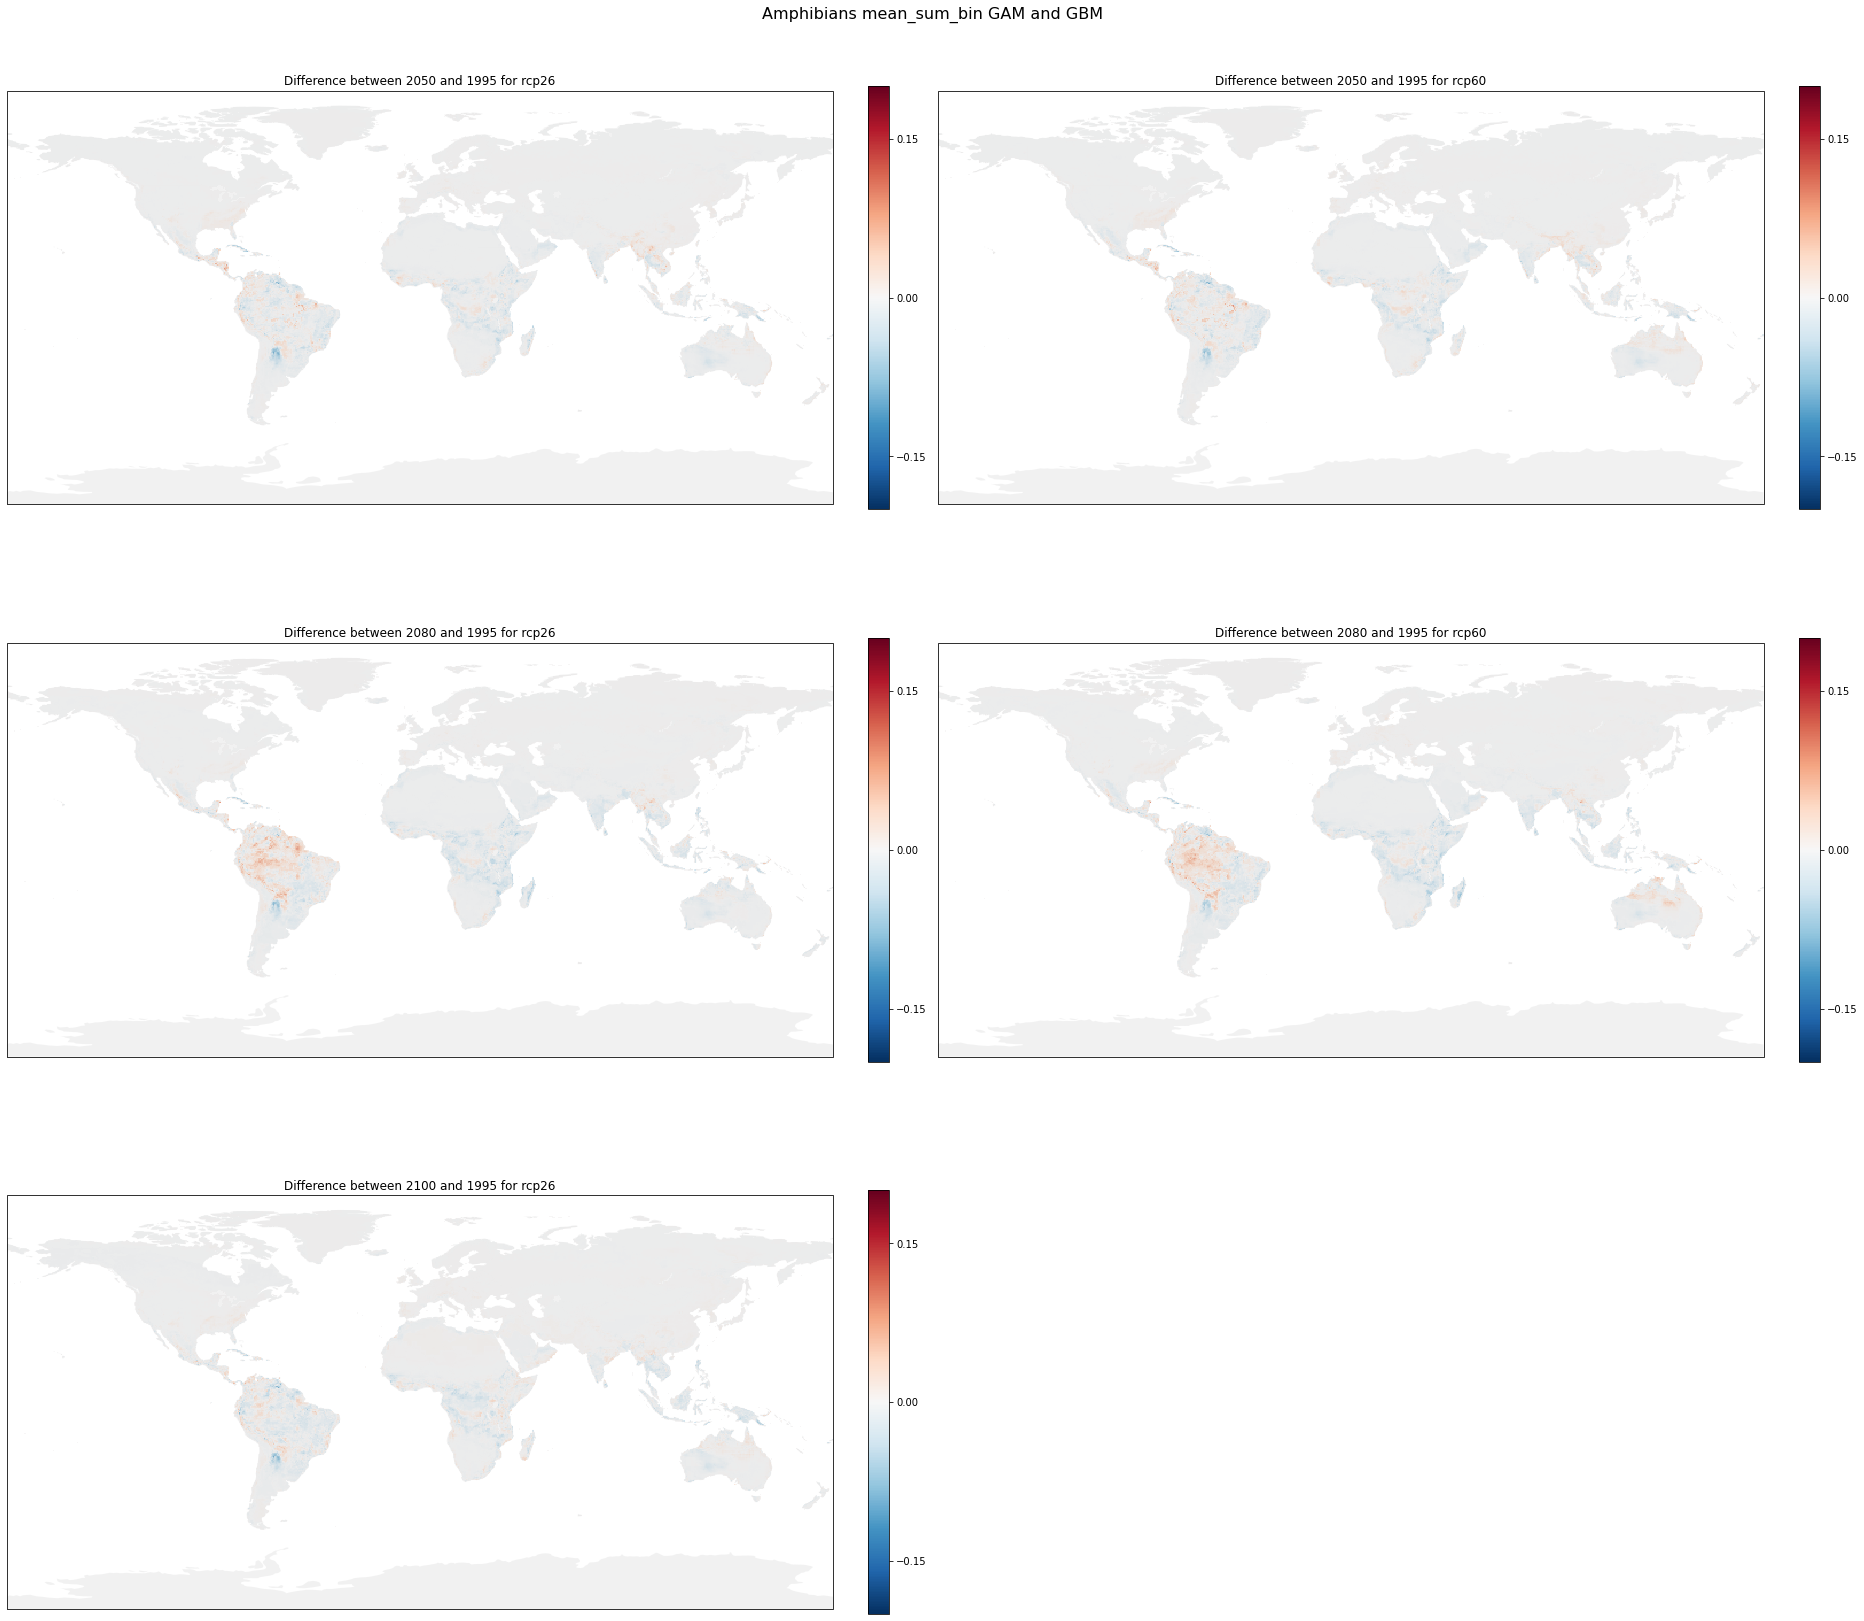

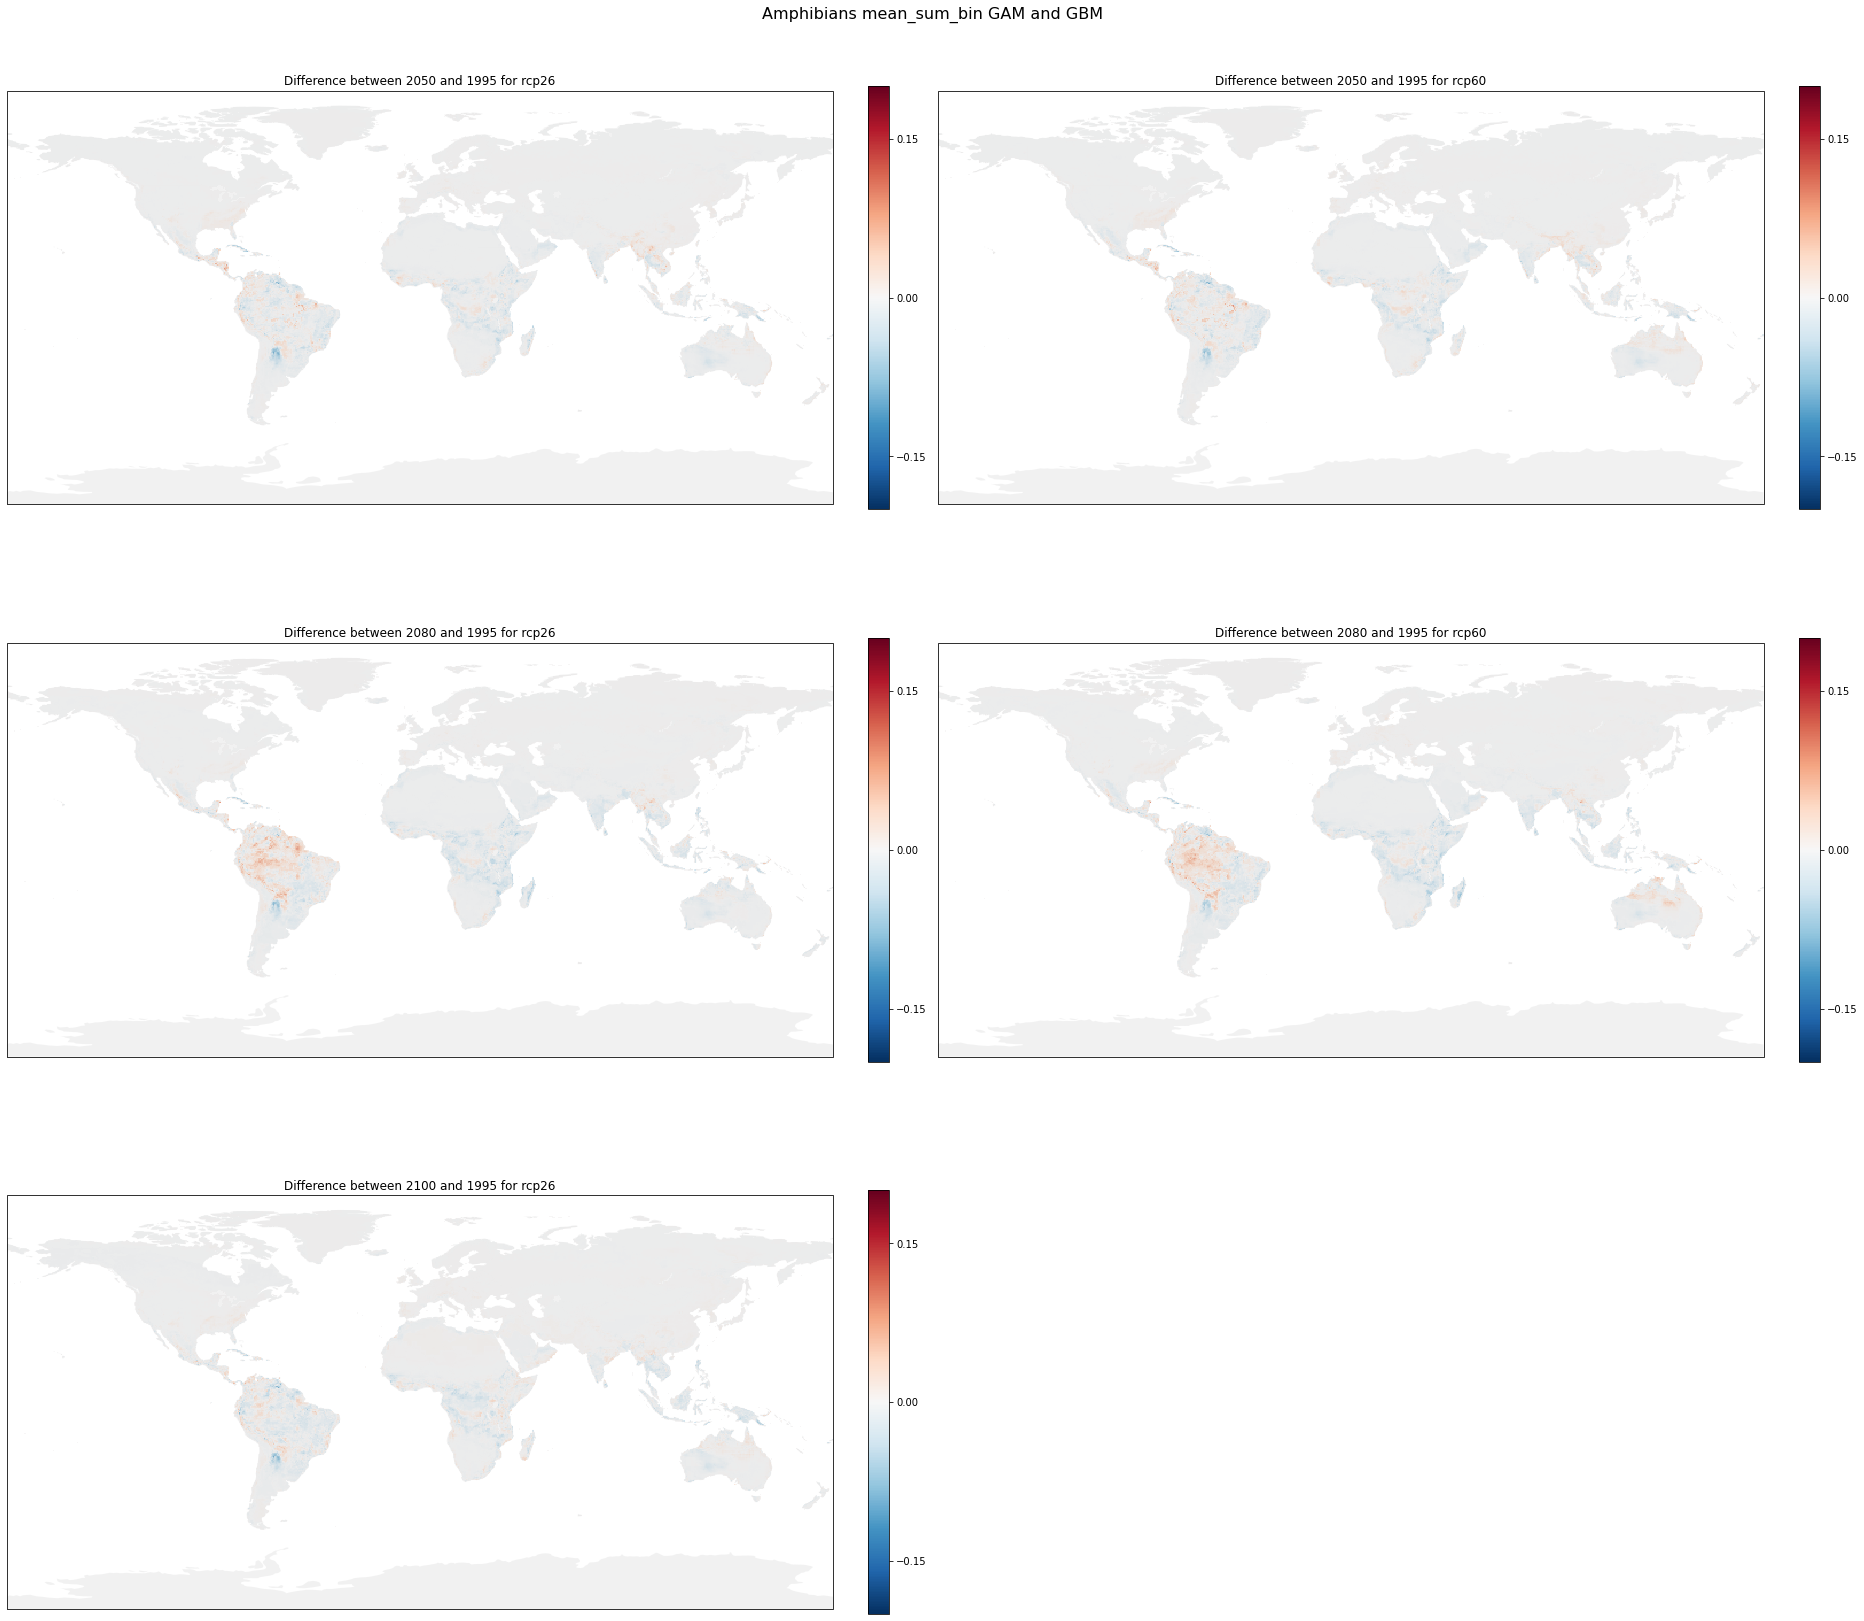

In [67]:
#### species richness SDM mean #### 

models=["GAM","GBM"]
years= ['1845', '1990', '1995', '2009', '2010', '2020', '2026', '2032', '2048', '2050', 
                 '2052', '2056', '2080', '2100', '2150', '2200', '2250']
model_names = ['GFDL-ESM2M', 'IPSL-CM5A-LR', 'HadGEM2-ES', 'MIROC5']

for taxa in taxas:
    species_names = {}
    for model in models:
        dir_species = "/storage/scratch/users/ch21o450/data/LandClim_Output/" + model + "/" + taxa + "/EWEMBI/"
        available_file = os.listdir(dir_species)
        available_names = [x.split("_[1146].nc")[0] for x in available_file]
        species_names_model = available_names[:100]
        species_names[model] = species_names_model


for taxa in taxas:
    for model in models:
        def calculate_model_mean(time, models, model_names, netcdf_path_format, is_historical=False, scenario=None):
            sum_bin_dict = {model: {model_name: {} for model_name in model_names} for model in models}

            for model in models:
                for model_name in model_names:
                    for species_name in species_names[model]:
                        if is_historical:
                            ds = xr.open_dataset(netcdf_path_format.format(model, taxa,  species_name, time), decode_times=False)
                        else:
                            ds = xr.open_dataset(netcdf_path_format.format(model,taxa, model_name, scenario, species_name, time), decode_times=False)
                        sum_bin = ds["sum_bin"]
                        sum_bin_dict[model][model_name][species_name] = sum_bin

            projections_dict = {}

            for species_name in species_names[model]:
                sum_bin_list = []
                for model in models:
                    for model_name in model_names:
                        sum_bin = sum_bin_dict[model][model_name][species_name]
                        sum_bin_list.append(sum_bin)
                sum_bin_concat = xr.concat(sum_bin_list, dim="model")
                mean_sum_bin = sum_bin_concat.mean(dim="model")
                projections_dict[species_name] = mean_sum_bin

            mean_sum_bin_list = list(projections_dict.values())
            mean_sum_bin = xr.concat(mean_sum_bin_list, dim="species").mean(dim="species")

            return mean_sum_bin



        historical_time = 1146
        future_times = [35, 65, 85]
        scenarios = ["rcp26", "rcp60"]
        model_names = ['GFDL-ESM2M', 'IPSL-CM5A-LR', 'HadGEM2-ES', 'MIROC5']
        netcdf_path_format_future = "/storage/scratch/users/ch21o450/data/LandClim_Output/{}/{}/{}/{}/{}_[{}].nc"
        netcdf_path_format_hist = "/storage/scratch/users/ch21o450/data/LandClim_Output/{}/{}/EWEMBI/{}_[{}].nc"

        mean_hist_gam = calculate_model_mean(historical_time, ["GAM"], model_names, netcdf_path_format_hist, is_historical=True)
        mean_hist_gbm = calculate_model_mean(historical_time, ["GBM"], model_names, netcdf_path_format_hist, is_historical=True)
        mean_hist = (mean_hist_gam + mean_hist_gbm) / 2

        fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(26, 24), subplot_kw={'projection': ccrs.PlateCarree()})
        cmap = matplotlib.colors.ListedColormap(['white', 'green'])
        countries = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))

        plot_idx = 0
        year_indices = {1146: '1995', 35: '2050', 65: '2080', 85: '2100'}

        for future_time in future_times:
            if future_time == 35 or future_time == 65:
                model_names = ['GFDL-ESM2M', 'IPSL-CM5A-LR', 'HadGEM2-ES', 'MIROC5']
                scenarios = ["rcp26", "rcp60"]
            elif future_time == 85:
                model_names = ['IPSL-CM5A-LR', 'HadGEM2-ES', 'MIROC5']
                scenarios = ["rcp26"]

            for scenario in scenarios:
                if future_time == 85 and scenario == "rcp60":
                    continue

                mean_future_gam = calculate_model_mean(future_time, ["GAM"], model_names, netcdf_path_format_future, is_historical=False, scenario=scenario)
                mean_future_gbm = calculate_model_mean(future_time, ["GBM"], model_names, netcdf_path_format_future, is_historical=False, scenario=scenario)
                mean_future = (mean_future_gam + mean_future_gbm) /2

        # Select the 0th time slice in mean_future and mean_hist data arrays
                mean_future_slice = mean_future.isel(time=0)
                mean_hist_slice = mean_hist.isel(time=0)

                difference = mean_future_slice - mean_hist_slice
                ax = axes.flatten()[plot_idx]
                im = difference.plot(ax=ax, transform=ccrs.PlateCarree(), cmap="RdBu_r", add_colorbar=False, vmin=-0.2, vmax=0.2)

                countries.plot(ax=ax, color="lightgray", zorder=1, alpha=0.3)
                ax.set_title(f"Difference between {year_indices[future_time]} and {year_indices[historical_time]} for {scenario}")

                cbar = plt.colorbar(im, ax=ax, fraction=0.024, pad=0.04)
                cbar.set_ticks([-0.15, 0, 0.15])

                plot_idx += 1

            # Hide the last (empty) subplot
        axes.flatten()[-1].set_visible(False)
        plt.suptitle(taxa+ ' mean_sum_bin GAM and GBM', size=16)

        plt.tight_layout()


        fig.savefig("/storage/homefs/ch21o450/scripts/BioScenComb/plots/SDM_mean_" + taxa)


In [24]:
species_counts

NameError: name 'species_counts' is not defined

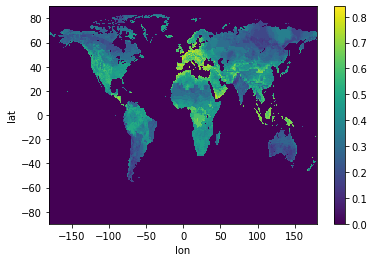

In [23]:
mean_future_gam.plot()

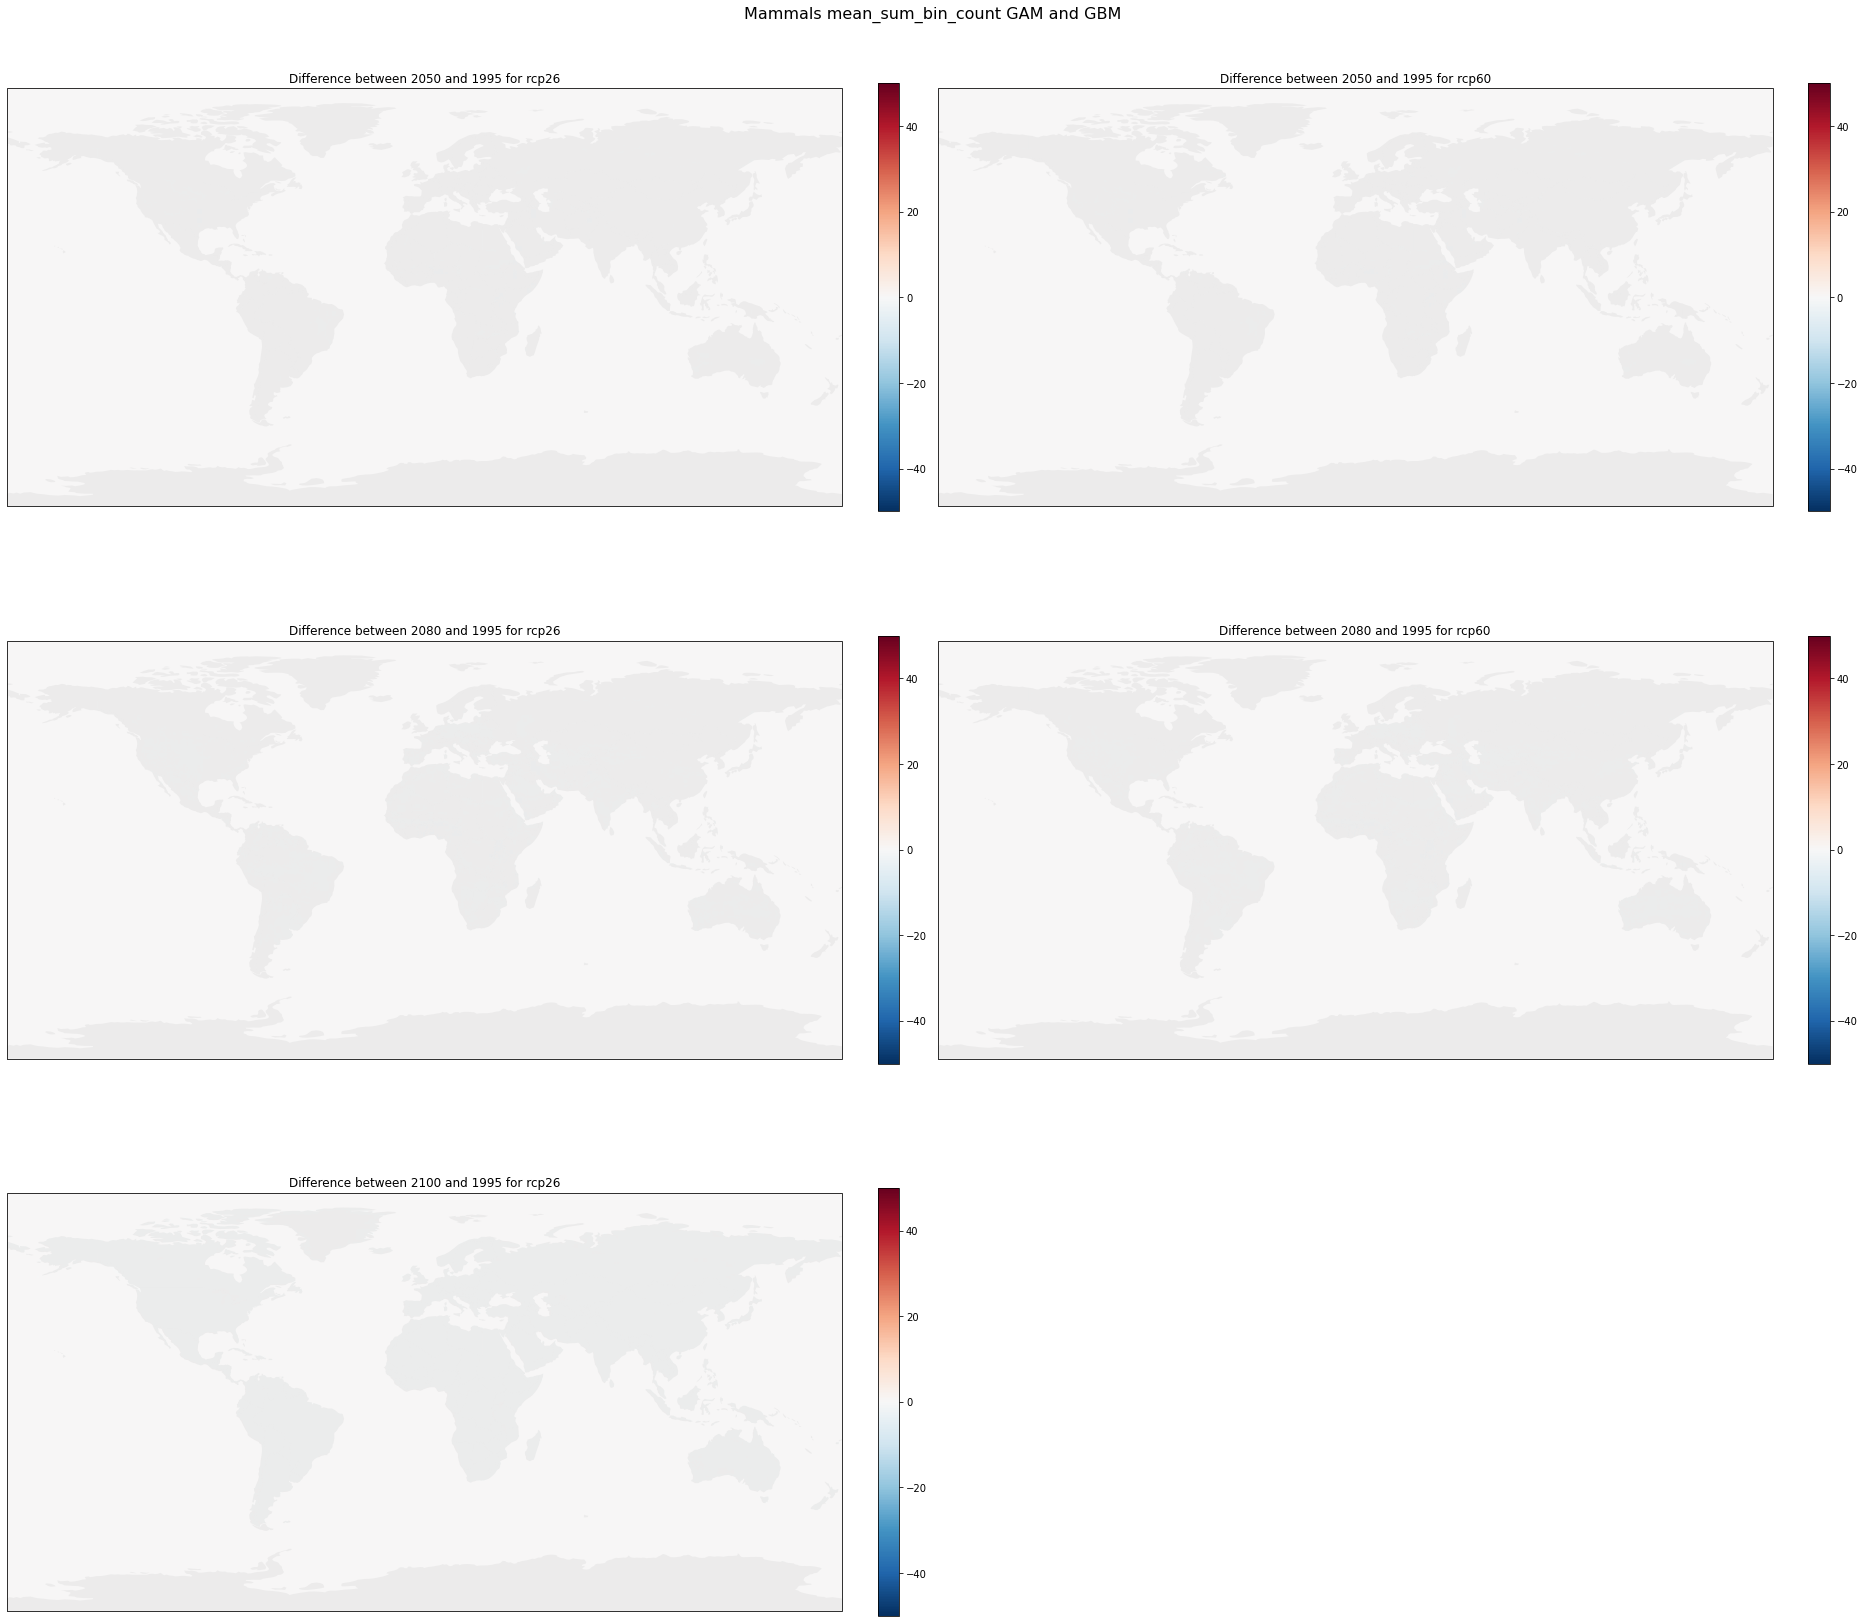

In [14]:
####Landclim effect count (species richness) #### SDM ensemmble mean 

#count 

taxas=["Mammals"]

models=["GAM","GBM"]
years= ['1845', '1990', '1995', '2009', '2010', '2020', '2026', '2032', '2048', '2050', 
                 '2052', '2056', '2080', '2100', '2150', '2200', '2250']
model_names = ['GFDL-ESM2M', 'IPSL-CM5A-LR', 'HadGEM2-ES', 'MIROC5']

for taxa in taxas:
    species_names = {}
    for model in models:
        dir_species = "/storage/scratch/users/ch21o450/data/LandClim_Output/" + model + "/" + taxa + "/EWEMBI/"
        available_file = os.listdir(dir_species)
        available_names = [x.split("_[1146].nc")[0] for x in available_file]
        species_names_model = available_names[:100]
        species_names[model] = species_names_model

for taxa in taxas:
    for model in models:
        def calculate_model_mean(time, models, model_names, netcdf_path_format, is_historical=False, scenario=None):
            species_counts_dict = {model: {model_name: {} for model_name in model_names} for model in models}

            for model in models:
                for model_name in model_names:
                    for species_name in species_names[model]:
                        if is_historical:
                            ds = xr.open_dataset(netcdf_path_format.format(model, taxa,  species_name, time), decode_times=False)
                        else:
                            ds = xr.open_dataset(netcdf_path_format.format(model,taxa, model_name, scenario, species_name, time), decode_times=False)
                        species_counts = xr.DataArray.sum(ds["sum_bin"] > 0, axis=0)  # Count the number of species present in each grid cell
                        species_counts_dict[model][model_name][species_name] = species_counts

            projections_dict = {}

            for species_name in species_names[model]:
                species_counts_list = []
                for model in models:
                    for model_name in model_names:
                        species_counts = species_counts_dict[model][model_name][species_name]
                        species_counts_list.append(species_counts)
                species_counts_array = np.array(species_counts_list)
                species_counts_concat = np.sum(species_counts_array > 0, axis=0)
                projections_dict[species_name] = species_counts_concat


            species_counts_list = list(projections_dict.values())
            species_counts = np.mean(species_counts_list, axis=0)
            #species_counts= species_counts_list

            return xr.DataArray(species_counts, coords=[ds.lat, ds.lon], dims=['lat', 'lon'])
        
    historical_time = 1146
    future_times = [35, 65, 85]
    scenarios = ["rcp26", "rcp60"]
    model_names = ['GFDL-ESM2M', 'IPSL-CM5A-LR', 'HadGEM2-ES', 'MIROC5']
    netcdf_path_format_future = "/storage/scratch/users/ch21o450/data/LandClim_Output/{}/{}/{}/{}/{}_[{}].nc"
    netcdf_path_format_hist = "/storage/scratch/users/ch21o450/data/LandClim_Output/{}/{}/EWEMBI/{}_[{}].nc"

    mean_hist_gam = calculate_model_mean(historical_time, ["GAM"], model_names, netcdf_path_format_hist, is_historical=True)
    mean_hist_gbm = calculate_model_mean(historical_time, ["GBM"], model_names, netcdf_path_format_hist, is_historical=True)
    mean_hist = (mean_hist_gam + mean_hist_gbm) / 2

    fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(26, 24), subplot_kw={'projection': ccrs.PlateCarree()})
    cmap = matplotlib.colors.ListedColormap(['white', 'green'])
    countries = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))

    plot_idx = 0
    year_indices = {1146: '1995', 35: '2050', 65: '2080', 85: '2100'}

    for future_time in future_times:
        if future_time == 35 or future_time == 65:
            model_names = ['GFDL-ESM2M', 'IPSL-CM5A-LR', 'HadGEM2-ES', 'MIROC5']
            scenarios = ["rcp26", "rcp60"]
        elif future_time == 85:
            model_names = ['IPSL-CM5A-LR', 'HadGEM2-ES', 'MIROC5']
            scenarios = ["rcp26"]

        for scenario in scenarios:
            if future_time == 85 and scenario == "rcp60":
                continue

            mean_future_gam = calculate_model_mean(future_time, ["GAM"], model_names, netcdf_path_format_future, is_historical=False, scenario=scenario)
            mean_future_gbm = calculate_model_mean(future_time, ["GBM"], model_names, netcdf_path_format_future, is_historical=False, scenario=scenario)
            mean_future = (mean_future_gam + mean_future_gbm) / 2

            difference = mean_future - mean_hist

            ax = axes.flatten()[plot_idx]
            im = difference.plot(ax=ax, transform=ccrs.PlateCarree(), cmap="RdBu_r", add_colorbar=False, vmin=-50, vmax=50)

            countries.plot(ax=ax, color="lightgray", zorder=1, alpha=0.3)
            ax.set_title(f"Difference between {year_indices[future_time]} and {year_indices[historical_time]} for {scenario}")

            cbar = plt.colorbar(im, ax=ax, fraction=0.024, pad=0.04)
            #cbar.set_ticks([-500,-200,-100,-50, 0,50,100,200, 500])

            plot_idx += 1

        # Hide the last (empty) subplot
    axes.flatten()[-1].set_visible(False)
    plt.suptitle(taxa+ ' mean_sum_bin_count GAM and GBM', size=16)

    plt.tight_layout()
    plt.show()
     
     

ValueError: too many values to unpack (expected 2)

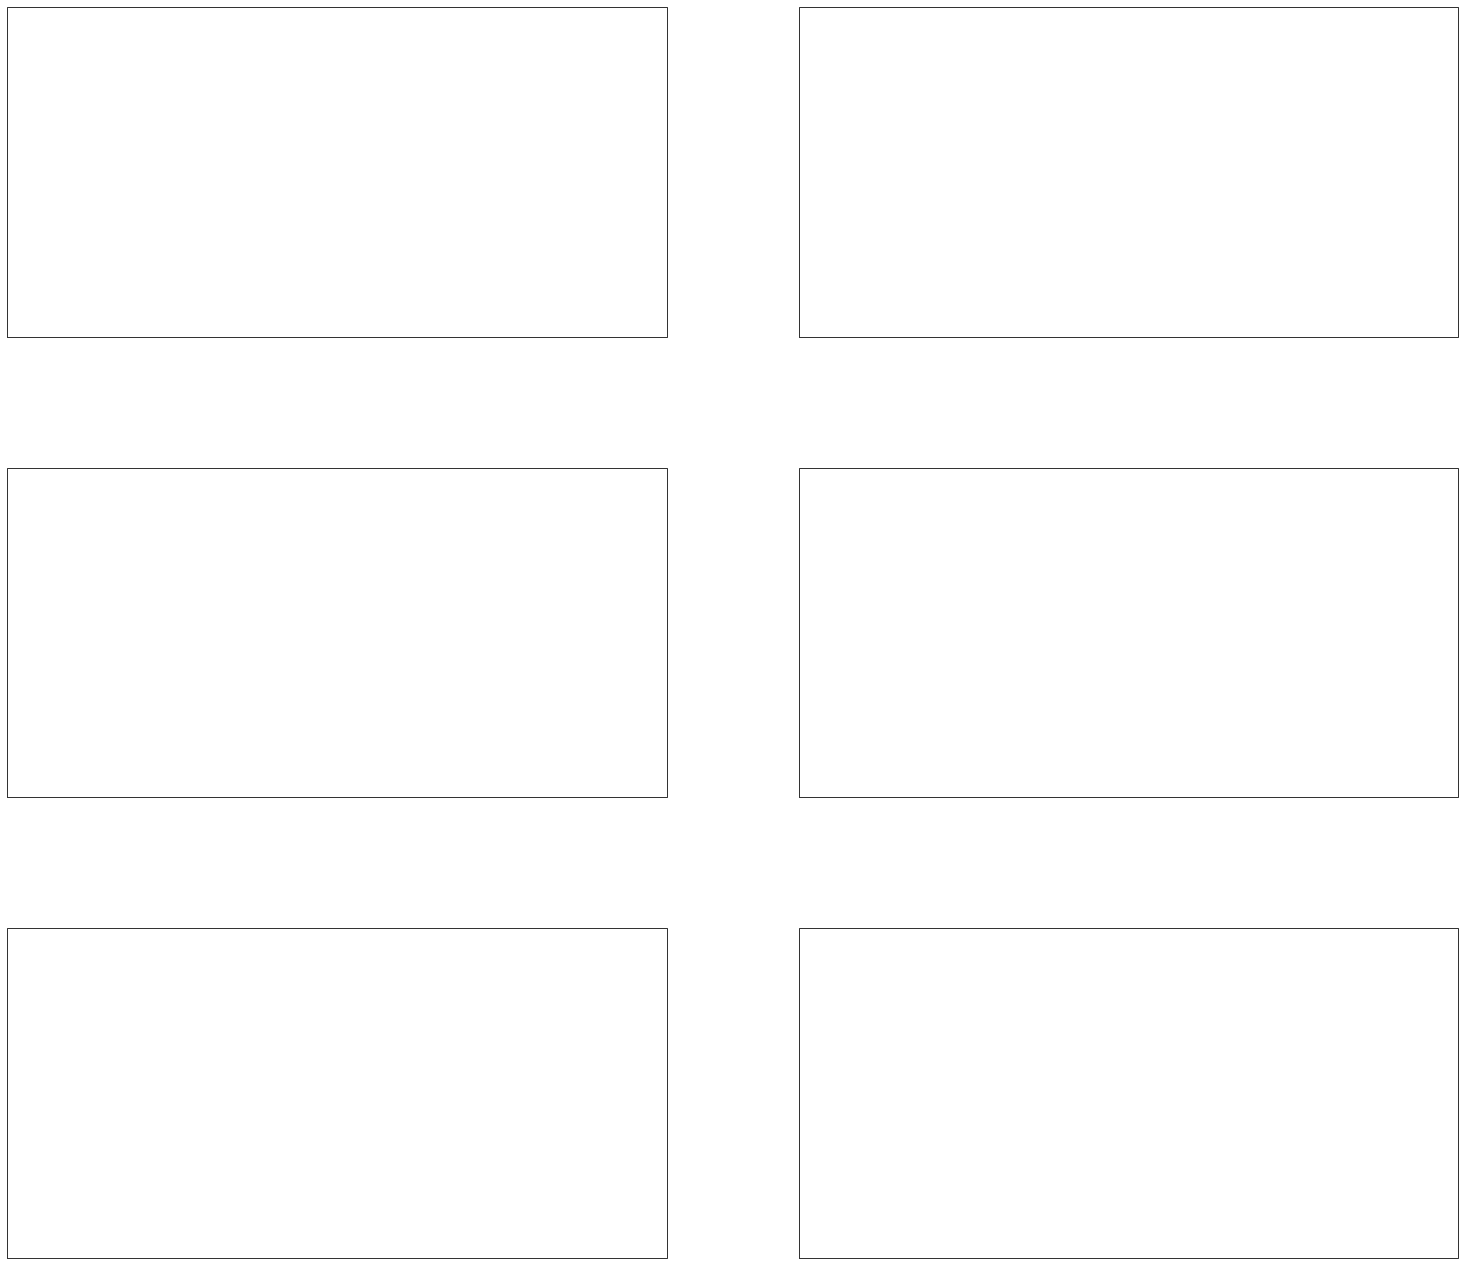

In [77]:
####Landclim effect extinction #### SDM ensemmble mean 


taxas=["Mammals"]

models=["GAM","GBM"]
years= ['1845', '1990', '1995', '2009', '2010', '2020', '2026', '2032', '2048', '2050', 
                 '2052', '2056', '2080', '2100', '2150', '2200', '2250']
model_names = ['GFDL-ESM2M', 'IPSL-CM5A-LR', 'HadGEM2-ES', 'MIROC5']

for taxa in taxas:
    species_names = {}
    for model in models:
        dir_species = "/storage/scratch/users/ch21o450/data/LandClim_Output/" + model + "/" + taxa + "/EWEMBI/"
        available_file = os.listdir(dir_species)
        available_names = [x.split("_[1146].nc")[0] for x in available_file]
        species_names_model = available_names
        species_names[model] = species_names_model[:100]

for taxa in taxas:
    for model in models:
        def calculate_model_mean(time, models, model_names, netcdf_path_format, is_historical=False, scenario=None):
            species_counts_dict = {model: {model_name: {} for model_name in model_names} for model in models}

            for model in models:
                for model_name in model_names:
                    for species_name in species_names[model]:
                        if is_historical:
                            ds = xr.open_dataset(netcdf_path_format.format(model, taxa,  species_name, time), decode_times=False)
                        else:
                            ds = xr.open_dataset(netcdf_path_format.format(model,taxa, model_name, scenario, species_name, time), decode_times=False)
                        species_counts = xr.DataArray.sum(ds["sum_bin"] > 0, axis=0)  # Count the number of species present in each grid cell
                        species_counts_dict[model][model_name][species_name] = species_counts

            projections_dict = {}

            for species_name in species_names[model]:
                species_counts_list = []
                for model in models:
                    for model_name in model_names:
                        species_counts = species_counts_dict[model][model_name][species_name]
                        species_counts_list.append(species_counts)
                species_counts_concat = np.mean(species_counts_list, axis=0)  
                projections_dict[species_name] = species_counts_concat

            species_counts_list = list(projections_dict.values())
            species_counts = np.mean(species_counts_list, axis=0) 

            return xr.DataArray(species_counts, coords=[ds.lat, ds.lon], dims=['lat', 'lon'])

        def count_extinct_species(past_data, future_data):
            return xr.DataArray.sum((past_data > 0) & (future_data == 0), axis=0)

    historical_time = 1146
    future_times = [35, 65, 85]
    scenarios = ["rcp26", "rcp60"]
    model_names = ['GFDL-ESM2M', 'IPSL-CM5A-LR', 'HadGEM2-ES', 'MIROC5']
    netcdf_path_format_future = "/storage/scratch/users/ch21o450/data/LandClim_Output/{}/{}/{}/{}/{}_[{}].nc"
    netcdf_path_format_hist = "/storage/scratch/users/ch21o450/data/LandClim_Output/{}/{}/EWEMBI/{}_[{}].nc"

    mean_hist_gam = calculate_model_mean(historical_time, ["GAM"], model_names, netcdf_path_format_hist, is_historical=True)
    mean_hist_gbm = calculate_model_mean(historical_time, ["GBM"], model_names, netcdf_path_format_hist, is_historical=True)
    mean_hist = (mean_hist_gam + mean_hist_gbm) / 2

    fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(26, 24), subplot_kw={'projection': ccrs.PlateCarree()})
    cmap = matplotlib.colors.ListedColormap(['white', 'green'])
    countries = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))

    plot_idx = 0
    year_indices = {1146: '1995', 35: '2050', 65: '2080', 85: '2100'}

    for future_time in future_times:
        if future_time == 35 or future_time == 65:
            model_names = ['GFDL-ESM2M', 'IPSL-CM5A-LR', 'HadGEM2-ES', 'MIROC5']
            scenarios = ["rcp26", "rcp60"]
        elif future_time == 85:
            model_names = ['IPSL-CM5A-LR', 'HadGEM2-ES', 'MIROC5']
            scenarios = ["rcp26"]

        for scenario in scenarios:
            if future_time == 85 and scenario == "rcp60":
                continue

            mean_future_gam = calculate_model_mean(future_time, ["GAM"], model_names, netcdf_path_format_future, is_historical=False, scenario=scenario)
            mean_future_gbm = calculate_model_mean(future_time, ["GBM"], model_names, netcdf_path_format_future, is_historical=False, scenario=scenario)
            mean_future = (mean_future_gam + mean_future_gbm) / 2

            difference = mean_future - mean_hist

            mean_past_gam, mean_future_gam = calculate_model_mean(future_time, ["GAM"], model_names, netcdf_path_format_future, is_historical=False, scenario=scenario)
            mean_past_gbm, mean_future_gbm = calculate_model_mean(future_time, ["GBM"], model_names, netcdf_path_format_future, is_historical=False, scenario=scenario)

            extinct_species_gam = count_extinct_species(mean_past_gam, mean_future_gam)
            extinct_species_gbm = count_extinct_species(mean_past_gbm, mean_future_gbm)
            extinct_species = (extinct_species_gam + extinct_species_gbm) / 2

            # Replace 'difference' with 'extinct_species' in the plotting code
            ax = axes.flatten()[plot_idx]
            im = extinct_species.plot(ax=ax, transform=ccrs.PlateCarree(), cmap="RdBu_r", add_colorbar=False, vmin=0)

            countries.plot(ax=ax, color="lightgray", zorder=1, alpha=0.3)
            ax.set_title(f"Difference between {year_indices[future_time]} and {year_indices[historical_time]} for {scenario}")

            cbar = plt.colorbar(im, ax=ax, fraction=0.024, pad=0.04)
            cbar.set_ticks([-6, 0, 6])

            plot_idx += 1

        # Hide the last (empty) subplot
    axes.flatten()[-1].set_visible(False)
    plt.suptitle(taxa+ ' mean_sum_bin GAM and GBM', size=16)

    plt.tight_layout()
    plt.show()
     

